In [ ]:
!pip install pytorch-lightning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# VAE Encoder Part

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

# from decoder import VAE_AttentionBlock, VAE_ResidualBlock

In [ ]:
class VAE_Encoder(nn.Module):
  # Difference between nn.Sequential and nn.Module
  # nn.Sequential do not need to define the forward pass
  def __init__(self):
    super().__init__()
    self.layers = nn.ModuleList([
        # shape:(B, C, H, W) -> (B, 128, H, W)
        nn.Conv2d(3, 128, kernel_size=3, padding=1),

        # shape:(B, 128, H, W) -> (B, 128, H, W)
        VAE_ResidualBlock(128,128),

        # shape:(B, 128, H, W) -> (B, 128, H, W)
        VAE_ResidualBlock(128,128),

        # shape:(B, 128, H, W) -> (B, 128, H / 2, W / 2)
        nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),

        # shape:(B, 128, H / 2, W / 2) -> (B, 256, H / 2, W / 2)
        VAE_ResidualBlock(128,256),

        # shape:(B, 256, H / 2, W / 2) -> (B, 256, H / 2, W / 2)
        VAE_ResidualBlock(256,256),

        # shape:(B, 256, H / 2, W / 2) -> (B, 256, H / 4, W / 4)
        nn.Conv2d(256,256, kernel_size=3, stride=2, padding=0),

        # shape:(B, 256, H / 4, W / 4) -> (B, 512, H / 4, W / 4)
        VAE_ResidualBlock(256,512),

        # shape:(B, 512, H / 4, W / 4) -> (B, 512, H / 4, W / 4)
        VAE_ResidualBlock(512,512),

        # shape:(B, 512, H / 4, W / 4) -> (B, 512, H / 8, W / 8)
        nn.Conv2d(512,512, kernel_size=3, stride=2, padding=0),

        VAE_ResidualBlock(512,512),

        VAE_ResidualBlock(512,512),

        # shape: (B, 512, H / 8, W / 8) -> (B, 512, H / 8, W / 8)
        VAE_ResidualBlock(512,512),

        # shape: (B, 512, H / 8, W / 8) -> (B, 512, H / 8, W / 8)
        VAE_AttentionBlock(512),

        # shape: (B, 512, H / 8, W / 8) -> (B, 512, H / 8, W / 8)
        VAE_ResidualBlock(512,512),

        # GroupNorm: Divde the total 512 features into 32 groups and calculate the mean and variance and normlized so on.
        # shape: (B, 512, H / 8, W / 8) -> (B, 512, H / 8, W / 8)
        nn.GroupNorm(32, 512),

        # shape: (B, 512, H / 8, W / 8) -> (B, 512, H / 8, W / 8)
        nn.SiLU(),

        # shape: (B, 512, H / 8, W / 8) -> (B, 8, H / 8, W / 8)
        nn.Conv2d(512,8, kernel_size=3, padding=1),

        # shape: (B, 8, H / 8, W / 8) -> (B, 8, H / 8, W / 8)
        nn.Conv2d(8,8, kernel_size=1, padding=0)
    ])


  def forward(self, x: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
    # x.shape = (B, C, H, W)
    # noise.shape = (B, 4, H / 8, W / 8)

    for module in self.layers:
      if getattr(module, 'stride', None) == (2, 2):
        # Do a asymmetric padding only for right and bottom
        x = F.pad(x, (0, 1, 0, 1))
      # The output of the VAE is mean and logvar
      x = module(x)

    # torch.chunk
    # Parameters:
      # input (Tensor) – the tensor to split
      # chunks (int) – number of chunks to return
      # dim (int) – dimension along which to split the tensor
    # shape: (B, 8, H / 8, W / 8) -> two tensor with shape: (B, 4, H / 8, W / 8)
    mean, logvar = torch.chunk(x, 2, dim=1)

    # torch.clamp
    # Clamps all elements in input into the range [ min, max ]. Letting min_value and max_value be min and max.
    # logvar.shape = (B, 4, H / 8, W / 8) -> (B, 4, H / 8, W / 8)
    logvar = logvar.clamp(-30, 20)

    # Convert to stdev
    # logvar.shape = (B, 4, H / 8, W / 8) -> (B, 4, H / 8, W / 8)
    stdev = torch.exp(logvar * 0.5)

    # Reparameterization trick
    x = mean + stdev * noise

    # Scale the output by a constant
    x *= 0.18215


    return x



# VAE Decoder Part

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
# from attention import SelfAttention

In [ ]:
class VAE_AttentionBlock(nn.Module):
  """Define the Attention Block"""
  def __init__(self, in_channels: int):
    super().__init__()
    self.groupnorm = nn.GroupNorm(32, in_channels)
    self.attention = SelfAttention(1, in_channels)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # x.shape = (B, in_channels, H, W)

    residue = x

    x = self.groupnorm(x)

    # acquire the shape of the input tensor
    n, c, h, w = x.shape

    # x.shape = (B, in_channels, H, W) -> (B, in_channels, H*W)
    x = x.view(n, c, h * w)

    # x.shape = (B, in_channels, H*W) -> (B, H*W, in_channels)
    x = x.transpose(-1, -2)

    # x.shape = (B, H*W, in_channels) -> (B, H*W, in_channels)
    x = self.attention(x)

    # x.shape = (B, H*W, in_channels) -> (B, in_channels, H*W)
    x = x.transpose(-1, -2)

    # x.shape = (B, in_channels, H*W) -> (B, in_channels, H, W)
    x = x.view(n, c, h, w)

    return x + residue





class VAE_ResidualBlock(nn.Module):
  """Define the Residual Block"""
  def __init__(self, in_channels: int, out_channels: int):
    super().__init__()
    self.groupnorm_1 = nn.GroupNorm(32, in_channels)
    self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    self.groupnorm_2 = nn.GroupNorm(32, out_channels)
    self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    if in_channels == out_channels:
      # nn.Identity(): Return the input as output
      # Basically, the input = output. It act like a placeholder
      self.residual_layer = nn.Identity()
    else:
      # 1 * 1 Conv does not change the H and W only the C dimension
      self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # x.shape = (B, in_channels, H, W)

    residue = x

    x = self.groupnorm_1(x)

    x = F.silu(x)

    x = self.conv_1(x)

    x = self.groupnorm_2(x)

    x = F.silu(x)

    x = self.conv_2(x)

    # This been used to handle when the in_channels != out_channels
    return x + self.residual_layer(residue)





class VAE_Decoder(nn.Module):
  """Define the Decoder"""
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        # The output shape from encoder is (B, 4, H / 8, W / 8)

        # shape: (B, 4, H / 8, W / 8) -> (B, 4, H / 8, W / 8)
        nn.Conv2d(4, 4, kernel_size=1, padding=0),

        # shape: (B, 4, H / 8, W / 8) -> (B, 512, H / 8, W / 8)
        nn.Conv2d(4, 512, kernel_size=3, padding=1),

        # shape: (B, 512, H / 8, W / 8) -> (B, 512, H / 8, W / 8)
        VAE_ResidualBlock(512,512),

        # shape: (B, 512, H / 8, W / 8) -> (B, 512, H / 8, W / 8)
        VAE_AttentionBlock(512),

        VAE_ResidualBlock(512,512),

        VAE_ResidualBlock(512,512),

        VAE_ResidualBlock(512,512),

        # shape: (B, 512, H / 8, W / 8) -> (B, 512, H / 8, W / 8)
        VAE_ResidualBlock(512,512),

        # Increase the size of each images
        # shape: (B, 512, H / 8, W / 8) -> (B, 512, H / 4, W / 4)
        nn.Upsample(scale_factor=2, mode='nearest'),

        nn.Conv2d(512, 512, kernel_size=3, padding=1),

        VAE_ResidualBlock(512,512),
        VAE_ResidualBlock(512,512),
        VAE_ResidualBlock(512,512),

        # shape: (B, 512, H / 4, W / 4) -> (B, 512, H / 2, W / 2)
        nn.Upsample(scale_factor=2, mode='nearest'),

        nn.Conv2d(512, 512, kernel_size=3, padding=1),

        # shape: (B, 512, H / 2, W / 2) -> (B, 256, H / 2, W / 2)
        VAE_ResidualBlock(512,256),
        VAE_ResidualBlock(256,256),
        VAE_ResidualBlock(256,256),

        # shape: (B, 256, H / 2, W / 2) -> (B, 256, H, W)
        nn.Upsample(scale_factor=2, mode='nearest'),


        nn.Conv2d(256, 256, kernel_size=3, padding=1),

        # shape: (B, 256, H, W) -> (B, 128, H, W)
        VAE_ResidualBlock(256,128),
        VAE_ResidualBlock(128,128),
        VAE_ResidualBlock(128,128),

        nn.GroupNorm(32, 128),

        nn.SiLU(),

        # shape: (B, 128, H, W) -> (B, 3, H, W)
        nn.Conv2d(128, 3, kernel_size=3, padding=1)
    )


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # x.shape = (B, 4, H / 8, W / 8)

    # Reverse the scaler constant
    x /= 0.18215


    # x.shape = (B, 3, H, W)
    return self.layers(x)


# Attention Part

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import math

In [ ]:
class SelfAttention(nn.Module):
  """Self Attention"""
  def __init__(self, n_heads: int, d_embed: int, in_proj_bias = True, out_proj_bias = True):
    super().__init__()

    # Define the giant linear layer
    self.in_proj = nn.Linear(d_embed, d_embed * 3, bias=in_proj_bias)

    # Define the output_project layer
    self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)

    # Define the number of heads
    self.num_heads = n_heads

    # Define the dim of each heads
    self.head_dim = d_embed // n_heads

  def forward(self, x: torch.Tensor, causal_mask = False) -> torch.Tensor:
    # x.shape = (B, T, d)

    batch_size, seq_len, d_embed = x.shape

    # qkv.shape = (B, T, 3d) -> (B, T, 3, h, d//h)
    qkv = self.in_proj(x).view(batch_size, seq_len, 3, self.num_heads, self.head_dim)

    # qkv.shape = (B, T, 3, h, d//h) -> (3, B, h, T, d//h)
    qkv = qkv.permute(2, 0, 3, 1, 4)

    # q, k, v.shape = (3, B, h, T, d//h) -> 3 tensors with shape (B, h, T, d//h)
    q, k, v = qkv.unbind(0)

    # atten_weight.shape = (B, h, T, d//h) -> (B, h, T, T)
    atten_weight = torch.matmul(q, k.transpose(-1, -2))

    # Construct the causal_mask
    if causal_mask:
      mask = torch.ones_like(atten_weight, dtype=torch.bool, device=x.device).triu(1)
      atten_weight = atten_weight.masked_fill(mask, float('-inf'))

    # atten_score.shape = (B, h, T, d//h) -> (B, h, T, T)
    atten_score = F.softmax(atten_weight / math.sqrt(k.shape[-1]), dim=-1)

    # context_vec.shape = (B, h, T, T) -> (B, h, T, d//h) -> (B, T, h, d//h)
    context_vec = torch.matmul(atten_score, v).transpose(1, 2)

    # context_vec.shape = (B, T, h, d//h) -> (B, T, d)
    context_vec = context_vec.contiguous().view(batch_size, seq_len, d_embed)

    # context_vec.shape = (B, T, d)
    return self.out_proj(context_vec)





class CrossAttention(nn.Module):
  """Cross Attention for UNET"""
  def __init__(self, n_heads: int, d_embed: int, d_context = int, in_proj_bias = True, out_proj_bias=True):
    super().__init__()
    self.q_proj = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
    self.k_proj = nn.Linear(d_context, d_embed, bias=in_proj_bias)
    self.v_proj = nn.Linear(d_context, d_embed, bias=in_proj_bias)
    self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
    self.n_heads = n_heads
    self.d_head = d_embed // n_heads

  def forward(self, x: torch.Tensor, context: torch.Tensor) -> torch.Tensor:
    # x(latent).shape = (B, seq_len_q, d_q) we changed the shape of the latent before invoke forward method
    # context.shape = (B, seq_len_k_v, d_k_v) = (B, 77, 768)

    B, seq_len, d_embed = x.shape

    # Regular method to calculate the q,k,v

    # q.shape = (B, seq_len_q, d_q) -> (B, seq_len_q, d_q)
    q = self.q_proj(x)

    # k.shape = (B, seq_len_k_v, d_k_v) -> (B, seq_len_k_v, d_q)
    k = self.k_proj(context)

    # v.shape = (B, seq_len_k_v, d_k_v) -> (B, seq_len_k_v, d_q)
    v = self.v_proj(context)

    # q.shape = (B, seq_len_q, d_q) -> (B, seq_len_q, self.n_heads, self.d_head) -> (B, self.n_heads, seq_len_q, self.d_head)
    q = q.view(B, seq_len, self.n_heads, self.d_head).transpose(1, 2)

    # k.shape = (B, seq_len_k_v, d_q) -> (B, seq_len_k_v, self.n_heads, self.d_head) -> (B, self.n_heads, seq_len_k_v, self.d_head)
    # Here we use -1 to replace the seq_len_k_v because for both tensors the d_embed is same after projection
    k = k.view(B, -1, self.n_heads, self.d_head).transpose(1, 2)

    # v.shape = (B, seq_len_k_v, d_q) -> (B, seq_len_k_v, self.n_heads, self.d_head) -> (B, self.n_heads, seq_len_k_v, self.d_head)
    v = v.view(B, -1, self.n_heads, self.d_head).transpose(1, 2)

    # attn_weight.shape = -> (B, self.n_heads, seq_len_q, self.d_head) @ (B, self.n_heads, self.d_head, seq_len_k_v) = (B, self.n_heads, seq_len_q, seq_len_k_v)
    attn_weight = torch.matmul(q, k.transpose(-1, -2))

    attn_score = F.softmax(attn_weight / math.sqrt(k.shape[-1]), dim=-1)

    # context_vec.shape = (B, self.n_heads, seq_len_q, seq_len_k_v) @ (B, self.n_heads, seq_len_k_v, self.d_head) = (B, self.n_heads, seq_len_q, self.d_head)
    context_vec = torch.matmul(attn_score, v)

    # context_vec.shape = (B, self.n_heads, seq_len_q, self.d_head) -> (B, seq_len_q, self.n_heads, self.d_head) -> (B, seq_len_q, d_q)
    context_vec = context_vec.transpose(1, 2).contiguous().view(B, seq_len, -1)

    # context_vec.shape = (B, seq_len_q, d_q)
    return self.out_proj(context_vec)


# CLIP Part

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
# from attention import SelfAttention


In [ ]:
class CLIPEmbedding(nn.Module):
  """CLIP word embedding"""
  def __init__(self, vocab_size: int, d_embed: int, max_seq_len: int):
    super().__init__()

    # General token embedding
    self.token_embedding = nn.Embedding(vocab_size, d_embed)

    # Positional embedding
    self.pos_embedding = nn.Parameter(torch.zeros(max_seq_len, d_embed))

  def forward(self, tokens: torch.LongTensor) -> torch.FloatTensor:
    # x.shape = (B, Seq_len, d) + (Seq_len, d) = (B, Seq_len, d)
    x = self.token_embedding(tokens) + self.pos_embedding
    return x





class CLIPLayer(nn.Module):
  """CLIP layer like the transformer block"""
  def __init__(self, n_heads: int, d_embed: int):
    super().__init__()

    self.layernorm_1 = nn.LayerNorm(d_embed)

    self.attention = SelfAttention(n_heads=n_heads, d_embed=d_embed)

    self.layernorm_2 = nn.LayerNorm(d_embed)

    self.linear_1 = nn.Linear(d_embed, d_embed * 4)

    self.linear_2 = nn.Linear(d_embed * 4, d_embed)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      # (B, Seq_Len, d)
      residue = x

      ### SELF ATTENTION ###

      x = self.layernorm_1(x)
      x = self.attention(x, causal_mask=True)
      x += residue

      ### FEEDFORWARD LAYER ###
      # Apply a feedforward layer where the hidden dimension is 4 times the embedding dimension.

      residue = x
      x = self.layernorm_2(x)
      x = self.linear_1(x)
      x = x * torch.sigmoid(1.702 * x)   # QuickGELU activation function
      x = self.linear_2(x)
      x += residue
      return x





class CLIP(nn.Module):
  """CLIP main block"""
  def __init__(self):
    super().__init__()
    # 49408 is the vocab_size
    # 768 is d_embedding
    # 77 is the longest sequence
    self.embedding = CLIPEmbedding(49408, 768, 77)

    self.layers = nn.Sequential(
        *[ CLIPLayer(12, 768) for _ in range(12) ]
    )

    self.layernorm = nn.LayerNorm(768)

  def forward(self, tokens: torch.LongTensor) -> torch.FloatTensor:
    # tokens.shape = (B, Seq_len)
    # tokens = tokens.type(torch.LongTensor)

    # x.shape = (B, Seq_len) -> (B, Seq_len, d)
    x = self.embedding(tokens)

    # x.shape = (B, Seq_len, d) -> (B, Seq_len, d)
    x = self.layers(x)

    # x.shape = (B, Seq_len, d) -> (B, Seq_len, d)
    return self.layernorm(x)


# Diffusion Part

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
# from attention import SelfAttention CrossAttention

In [ ]:
class TimeEmbedding(nn.Module):
  """Time Embedding"""
  def __init__(self, dim: int):
    super().__init__()

    self.layer = nn.Sequential(
        nn.Linear(dim, 4*dim),
        nn.SiLU(),
        nn.Linear(4*dim, 4*dim)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # x.shape = (1, 320) -> (1, 1280)
    return self.layer(x)





class UNET_ResidualBlock(nn.Module):
  """Residual Block for UNET"""
  ## This Block aims to merge the time information into the latent representation
  def __init__(self, in_channels: int, out_channels: int, n_time = 1280):
    super().__init__()
    self.groupnorm_feature = nn.GroupNorm(32, in_channels)
    self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    self.linear_time = nn.Linear(n_time, out_channels)

    self.groupnorm_merged = nn.GroupNorm(32, out_channels)
    self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    if in_channels == out_channels:
      self.residual_layer = nn.Identity()
    else:
      self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

  def forward(self, feature: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
    # feature(latent representation).shape = (B, in_channels, H, W)
    # time.shape = (1, 1280)

    residue = feature
    feature = self.groupnorm_feature(feature)
    feature = F.silu(feature)

    # feature.shape = (B, out_channels, H, W)
    feature = self.conv_feature(feature)
    time = F.silu(time)

    # time.shape = (1, out_channels)
    time = self.linear_time(time)

    # merged.shape = (B, out_channels, H, W) + (1, out_channels, 1, 1) = (B, out_channels, H, W)
    merged = feature + time.unsqueeze(-1).unsqueeze(-1)
    merged = self.groupnorm_merged(merged)
    merged = F.silu(merged)
    merged = self.conv_merged(merged)

    # return the shape (B, out_channels, H, W)
    return merged + self.residual_layer(residue)





class UNET_AttentionBlock(nn.Module):
  """Cross attention of the UNET"""
  def __init__(self, n_head: int, d_embd: int, d_context=768):
    super().__init__()
    channels = n_head * d_embd

    self.groupnorm = nn.GroupNorm(32, channels, eps = 1e-6)
    self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

    self.layernorm_1 = nn.LayerNorm(channels)
    self.attention_1 = SelfAttention(n_heads=n_head, d_embed=channels, in_proj_bias=False)
    self.layernorm_2 = nn.LayerNorm(channels)
    self.attention_2 = CrossAttention(n_heads=n_head, d_embed=channels, d_context=d_context, in_proj_bias=False)
    self.layernorm_3 = nn.LayerNorm(channels)
    self.linear_geglu_1 = nn.Linear(channels, 4 * channels * 2)
    self.linear_geglu_2 = nn.Linear(4 * channels, channels)

    self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

  def forward(self, x: torch.Tensor, context: torch.Tensor) -> torch.Tensor:
    # x is the latent space
    # x.shape = (B, C, H, W)
    # context.shape = (B, seq_len, d)

    residue_long = x

    x = self.groupnorm(x)

    x = self.conv_input(x)

    B, c, h, w = x.shape

    # x.shape = (B, C, H, W) -> (B, C, H*W) -> (B, H*W, C)
    x = x.view(B, c, h*w).transpose(-1, -2)

    ## Normalization + Self Attention with skip connection
    residue_short = x

    x = self.layernorm_1(x)
    x = self.attention_1(x)
    x += residue_short

    ## Normalization + Cross Attention with skip connection
    residue_short = x

    x = self.layernorm_2(x)
    # Cross Attention
    x = self.attention_2(x, context)
    x += residue_short

    ## Normalization + FFN with GeGLU and skip connection
    residue_short = x

    x = self.layernorm_3(x)

    # x.shape = (B, H*W, C) -> (B, H*W, 8*C) -> 2 tensors with shape (B, H*W, 4*C)
    x, gate = self.linear_geglu_1(x).chunk(2, dim=-1)

    # Element-wise product -> shape persist
    x = x * F.gelu(gate)

    # x.shape = (B, H*W, 4*C) -> (B, H*W, C)
    x = self.linear_geglu_2(x)

    x += residue_short

    # x.shape = (B, H*W, C) -> (B, C, H, W)
    x = x.transpose(-1, -2).contiguous().view(B, c, h, w)

    # x.shape = (B, C, H, W)
    return self.conv_output(x) + residue_long





class Upsample(nn.Module):
  """Upsample method in UNET"""
  def __init__(self, channels: int):
    super().__init__()
    self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # Assume the input tensor with shape: (B, C, H, W)
    # We return the tensor with shape: (B, C, H * 2, W * 2)
    # Here: F.interpolate(x, scale_factor=2, mode='nearest') is equvalent with: nn.Upsample(scale_factor=2, mode='nearest')
    x = F.interpolate(x, scale_factor=2, mode='nearest')
    return self.conv(x)





class SwitchSequential(nn.Module):
  """SwitchSequential class for UNET"""
  def __init__(self, layers):
      super().__init__()
      self.layers = nn.ModuleList(layers)

  def forward(self, x, context, time):
      for layer in self.layers:
          if isinstance(layer, UNET_AttentionBlock):
              x = layer(x, context)
          elif isinstance(layer, UNET_ResidualBlock):
              x = layer(x, time)
          else:
              x = layer(x)
      return x





class UNET(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoders = nn.ModuleList([
        # x.shape = (B, 4, H / 8, W / 8) -> (B, 320, H / 8, W / 8)
        SwitchSequential([nn.Conv2d(4, 320, kernel_size=3, padding=1)]),
        SwitchSequential([UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)]),
        SwitchSequential([UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)]),

        # x.shape = (B, 320, H / 8, W / 8) -> (B, 320, H / 16, W / 16)
        SwitchSequential([nn.Conv2d(320, 320, kernel_size=3, stride=2, padding=1)]),
        SwitchSequential([UNET_ResidualBlock(320, 640), UNET_AttentionBlock(8, 80)]),
        SwitchSequential([UNET_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)]),

        # x.shape = (B, 640, H / 16, W / 16) -> (B, 640, H / 32, W / 32)
        SwitchSequential([nn.Conv2d(640, 640, kernel_size=3, stride=2, padding=1)]),
        SwitchSequential([UNET_ResidualBlock(640, 1280), UNET_AttentionBlock(8, 160)]),
        SwitchSequential([UNET_ResidualBlock(1280, 1280), UNET_AttentionBlock(8, 160)]),

        # x.shape = (B, 1280, H / 32, W / 32) -> (B, 1280, H / 64, W / 64)
        SwitchSequential([nn.Conv2d(1280, 1280, kernel_size=3, stride=2, padding=1)]),
        SwitchSequential([UNET_ResidualBlock(1280, 1280)]),

        # x.shape = (B, 1280, H / 64, W / 64) -> (B, 1280, H / 64, W / 64)
        SwitchSequential([UNET_ResidualBlock(1280, 1280)])
    ])

    self.bottleneck = SwitchSequential([
        UNET_ResidualBlock(1280, 1280),
        UNET_AttentionBlock(8, 160),
        UNET_ResidualBlock(1280, 1280)
    ])

    self.decoders = nn.ModuleList([
        # x.shape = (B, 2560, H / 64, W / 64) -> (B, 1280, H / 64, W / 64)
        SwitchSequential([UNET_ResidualBlock(2560, 1280)]),

        SwitchSequential([UNET_ResidualBlock(2560, 1280)]),

        # x.shape = (B, 2560, H / 64, W / 64) -> (B, 1280, H / 64, W / 64) -> (B, 1280, H / 32, W / 32)
        SwitchSequential([UNET_ResidualBlock(2560, 1280), Upsample(1280)]),

        SwitchSequential([UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)]),

        SwitchSequential([UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)]),

        # x.shape = (B, 1920, H / 32, W / 32) -> (B, 1280, H / 32, W / 32) -> (B, 1280, H / 32, W / 32) -> (B, 1280, H / 16, W / 16)
        SwitchSequential([UNET_ResidualBlock(1920, 1280), UNET_AttentionBlock(8, 160), Upsample(1280)]),

        SwitchSequential([UNET_ResidualBlock(1920, 640), UNET_AttentionBlock(8, 80)]),

        SwitchSequential([UNET_ResidualBlock(1280, 640), UNET_AttentionBlock(8, 80)]),

        # x.shape = (B, 960, H / 16, W / 16) -> (B, 640, H / 16, W / 16) -> (B, 640, H / 16, W / 16) -> (B, 640, H / 8, W / 8)
        SwitchSequential([UNET_ResidualBlock(960, 640), UNET_AttentionBlock(8, 80), Upsample(640)]),

        SwitchSequential([UNET_ResidualBlock(960, 320), UNET_AttentionBlock(8, 40)]),

        SwitchSequential([UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)]),

        # x.shape = (B, 640, H / 8, W / 8) -> (B, 320, H / 8, W / 8)
        SwitchSequential([UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)])

    ])

  def forward(self, x, context, time):
        # x: (Batch_Size, 4, Height / 8, Width / 8)
        # context: (Batch_Size, Seq_Len, Dim)
        # time: (1, 1280)

        skip_connections = []
        for layers in self.encoders:
            x = layers(x, context, time)
            skip_connections.append(x)

        x = self.bottleneck(x, context, time)

        for layers in self.decoders:
            # Since we always concat with the skip connection of the encoder, the number of features increases before being sent to the decoder's layer
            x = torch.cat((x, skip_connections.pop()), dim=1)
            x = layers(x, context, time)

        return x



class UNET_OutputLayer(nn.Module):
  """The final layer of the UNET"""
  def __init__(self, in_channels: int, out_channels: int):
    super().__init__()
    self.groupnorm = nn.GroupNorm(32, in_channels)

    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # x.shape = (B, 320, H / 8, W / 8)
    x = self.groupnorm(x)
    x = F.silu(x)

    # x.shape = (B, 4, H / 8, W / 8)
    return self.conv(x)





class Diffusion(nn.Module):
  """Diffusion Model"""
  def __init__(self):
    super().__init__()
    self.time_embedding = TimeEmbedding(320)
    self.unet = UNET()
    self.final = UNET_OutputLayer(320, 4)


  def forward(self, latent: torch.Tensor, context: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
    # context is the prompt
    # latent.shape = (B, 4, H / 8, W / 8)
    # context.shape = (B, seq_len, d)
    # time.shape = (1, 320)

    # time.shape = (1, 320) -> (1, 1280)
    time = self.time_embedding(time)

    # output.shape = (B, 4, H / 8, W / 8) -> (B, 320, H / 8, W / 8)
    output = self.unet(latent, context, time)

    # output.shape = (B, 320, H / 8, W / 8) -> (B, 4, H / 8, W / 8)
    output = self.final(output)

    return output

# DDPM

In [ ]:
import torch
import numpy as np

In [ ]:
class DDPMSampler:
  """Define the denoise diffusion process"""
  def __init__(self, generator: torch.Generator, num_training_steps: int = 1000, beta_start: float = 0.00085, beta_end: float = 0.0120):
    # generator: Is the generator we used while generate the random noise as we init during the inference stage.
    # num_training_steps: The number of denoising steps we used for training.
    # beta_start and beta_end: is the variance schedular define by the author of ddpm

    # Init the variance scheduler(Linear)
    self.betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_training_steps, dtype = torch.float32) ** 2

    # Init the alpha
    self.alphas = 1.0 - self.betas

    # torch.cumprod:
    # Returns the cumulative product of elements of input in the dimension dim.
    # Init the cumprod of alpha
    # each element in self.alpha_cumprod is the alpha^bar
    # pos_0 = alpha_0, pos_1 = alpha_0 * alpha_1, pos_2 = alpha_0 * alpha_1,alpha_2, ....
    self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    self.one = torch.tensor(1.0)
    # Init the generator
    self.generator = generator

    # Init the num_training_steps
    self.num_training_steps = num_training_steps

    # Init the timesteps
    self.timesteps = torch.from_numpy(np.arange(0, num_training_steps)[::-1].copy())


  def set_inference_steps(self, num_inference_steps: int = 50):
    """Define the variance schedular for the inference stage."""
    ## Here no matter how we define the number of steps.
    # The requirement is that the variance schedular must reach 0 at the end.
    # Therefore, for inference stage, if we do 1000 steps, we take the step size = 1 where the schedular will decrease from 999 to 0.
    # Thus, if we take the inference steps = 50, we take the step size = 20 = 1000 // num_inference_steps .
    self.num_inference_steps = num_inference_steps
    step_ratio = self.num_training_steps // self. num_inference_steps

    # timesteps.output: [980 960 940 920 900 880 860 840 820 800 780 760 740 720 700 680 660 640
    # 620 600 580 560 540 520 500 480 460 440 420 400 380 360 340 320 300 280
    # 260 240 220 200 180 160 140 120 100  80  60  40  20   0]
    timesteps = ( np.arange( 0, num_inference_steps ) * step_ratio ).round()[::-1].copy().astype(np.int64)
    self.timesteps = torch.from_numpy(timesteps)



  def _get_previous_timestep(self, timestep: int) -> int:
    """Get the previous timestep"""
    prev_t = timestep - ( self.num_training_steps // self.num_inference_steps )
    return prev_t


  def _get_variance(self, timestep: int) -> torch.Tensor:
    """Get the variance"""
    prev_t = self._get_previous_timestep(timestep)

    alpha_prod_t= self.alpha_cumprod[ timestep ]
    alpha_prod_t_prev = self.alpha_cumprod[ prev_t ] if prev_t >= 0 else self.one

    current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev

    variance = ( 1 -  alpha_prod_t_prev ) / ( 1 - alpha_prod_t ) * current_beta_t
    variance = torch.clamp(variance, min = 1e-20)
    return variance

  def set_strength(self, strengh: float = 1.0):
    """Set the strength"""
    start_step = self.num_inference_steps - int(self.num_inference_steps * strengh)
    self.timesteps = self.timesteps[start_step:]
    self.start_step = start_step




  def step(self, timestep: int, latents: torch.Tensor, model_output: torch.Tensor):
    """Denoise step"""
    # model_output: The noise that the model predicted.
    t = timestep
    prev_t = self._get_previous_timestep(t)

    alpha_prod_t = self.alpha_cumprod[ t ]
    alpha_prod_t_prev = self.alpha_cumprod[ prev_t ] if prev_t >= 0 else self.one

    beta_prod_t = 1 - alpha_prod_t
    beta_prod_t_prev = 1 - alpha_prod_t_prev

    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    current_beta_t = 1 - current_alpha_t

    # Here, we use equation 15 of the DDPM to estimate the orginal image.
    # I have no idea why the video author use this method, but i do respect.
    # Could replaced with the sample algorithm of the orginal DDPM paper.
    pred_original_sample = ( latents - torch.sqrt(beta_prod_t) * model_output ) / torch.sqrt(alpha_prod_t)

    ## Use the formular I state for the DDPM note
    # Compute the coefficients for X_0
    pred_original_sample_coeff= ( torch.sqrt(alpha_prod_t_prev) * current_beta_t ) / beta_prod_t
    # Compute the coefficients for X_t
    current_sample_coeff = ( torch.sqrt(current_alpha_t) * beta_prod_t_prev ) / beta_prod_t

    # Compute the predicted mean of the previous step of image
    pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * latents

    variance = 0

    if t > 0:
      device = model_output.device
      noise = torch.randn(model_output.shape, generator=self.generator, device=device, dtype=model_output.dtype)
      variance = torch.sqrt(self._get_variance(t)) * noise

    # Reparameterization trick
    pred_prev_sample = pred_prev_sample + variance

    return pred_prev_sample





  def add_noise(self, original_samples: torch.FloatTensor, timesteps: torch.LongTensor) -> torch.FloatTensor:
    """Add noise to the original sample define the forward diffusion process"""

    # Move the tensor to the appropreate device
    alpha_cumprod = self.alpha_cumprod.to(device=original_samples.device, dtype=original_samples.dtype)
    timesteps = timesteps.to(device=original_samples.device)

    # Here, we calculate the sqrt of the alpha^bar part of the equation
    sqrt_alpha_prod = torch.sqrt(alpha_cumprod[timesteps]).flatten()

    # Keep expand the shape of the sqrt_alpha_cumprod tensor until it reach the shape of the original_samples tensor,
    # We doing this because of the boardcasting issues later while we adopt Reparameterization trick.
    while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
      sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)


    # Here, we calculate the (1-alpha^bar) part of the equation
    # Note that what we want eventually is the stdev not the variance
    sqrt_one_minus_alpha_prod = torch.sqrt(1.0 - alpha_cumprod[timesteps]).flatten() # This is stdev

    # Keep expand the shape of the sqrt_one_minus_alpha_cumprod tensor until it reach the shape of the original_samples tensor,
    # We doing this because of the boardcasting issues later while we adopt Reparameterization trick.
    while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
      sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

    # Now, we generate the noise accordingly in order to use the reparameterization trick
    noise = torch.randn(original_samples.shape, generator=self.generator, device=original_samples.device, dtype=original_samples.dtype)

    # noise_sample = mean + stdev * noise
    noise_sample = ( sqrt_alpha_prod * original_samples ) +  sqrt_one_minus_alpha_prod  * noise

    return noise_sample

# Pipeline

In [ ]:
import torch
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
# from ddpm import DDPMSampler


In [ ]:
WIDTH = 512
HEIGHT = 512
LATENTS_WIDTH = WIDTH // 8
LATENTS_HEIGHT = HEIGHT // 8
CHANNELS = 4

def get_time_embedding(timestep):
  # Might be incorrect
  """Using the same cos and sin wave like the transformer pos embedding"""
  # freqs.shape = (160, )
  freqs = torch.pow(10000, -torch.arange(start=0, end=160, dtype=torch.float32) / 160)

  # x.shape = (1, 160)
  # Here the timestep should be an integer
  # and torch.tensor([timestep], dtype=torch.float32) just convert this integer to the float point numbers.
  # torch.tensor([timestep], dtype=torch.float32)[:, None] add another dimension to this float point tensor,
  # let it become (1, 1).
  # Finally, we time that float tensor with the freqs tensor with shape (1, 160).
  x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]

  # x.shape = (1, 160) -> (1, 320)
  return torch.cat([x.cos(), x.sin()], dim=-1)

def rescale(x, old_range, new_range, clamp=False):
    old_min, old_max = old_range
    new_min, new_max = new_range
    x -= old_min
    x *= (new_max - new_min) / (old_max - old_min)
    x += new_min
    if clamp:
        x = x.clamp(new_min, new_max)
    return x

def generate(prompt: str,
             uncond_prompt: str,
             input_image = None,
             strength = 0.8,
             do_cfg = True,
             cfg_scale = 7.5,
             sampler_name = "ddpm",
             n_inference_steps = 50,
             models = {},
             seed = None,
             device = None,
             idle_device = None,
             tokenizer = None
             ):
  """Main function for generating images according to the prompt"""
 # prompt: The context used to generate the image accordingly
 # uncond_prompt: (Negative prompt) Suppose the user want a car, but who does not want it on the table; therefore, they could declare car within the uncond_prompt.
 # input_image: Used for image-to-image model that the user should provide an init image so that the model can modify it.
 # strength: Attention, how much weight we want to pay for the initial image. Large value means add more noise so that our model will be more creative.
 # do_cfg: True: Classifier-free guidence, False: Classifier-guidence.
 # cfg_scale: a int value in range (0-14) indicate the weight of the prompt.
 # sampler_name: The method we used to sample (generate the image), we use the denoise diffusion sample method to sample the image
 # n_inference_steps: Total number of the denoise sample steps.
 # models: The primary model we used to generate the image.
 # seed: The seed we used to generate the random numbers.
 # device: cuda for inference.
 # idle_device: cpu for reduce the workload of cuda.
 # tokenizer: The tokenizer we used to init the context.

  with torch.no_grad():

    if not ( 0<strength<=1):
      raise ValueError("Strength must be in range (0, 1]")

    ## Create a lambda function to reduce the amount of use of GPU that send the already used model to CPU
    if idle_device:
      to_idle = lambda x:x.to(idle_device)
    else:
      to_idle = lambda x:x # if we do not init the idle_device, this function will act like a identity placeholder.

    # generator is a generator object which like what we did when generate the number in pytorch
    generator = torch.Generator(device=device)

    if seed is not None:
      generator.manual_seed(seed)
    else:
      # This function Returns the initial seed for generating random numbers.
      generator.seed()

    clip = models['clip'].to(device)

    # Within the context of cfg, we inference our model twice.
    # Here is the formula:
    # output = w * ( output_condition(with prompt) - output_uncondition(without prompt) ) + output_uncondition
    # The reason this function be writen as this is becuase we want the final output is a linear combination of the condition output and uncondition output:
    # output = w * ( output_condition ) + (1-w) * ( output_uncondition )

    if do_cfg:
      # Convert the prompt into tokenizer
      cond_tokens = tokenizer.batch_encode_plus([prompt], padding='max_length', max_length=77).input_ids
      # (B, seq_len)
      cond_tokens = torch.LongTensor(cond_tokens).to(device)
      # cond_context.shape = (B, seq_len, d = 768) by passing through the CLIP model
      cond_context = clip(cond_tokens)

      # Convert the unconditional prompt into tokenizer
      uncond_tokens = tokenizer.batch_encode_plus([uncond_prompt], padding='max_length', max_length=77).input_ids
      # (B, seq_len)
      uncond_tokens = torch.LongTensor(uncond_tokens).to(device)
      # cond_context.shape = (B, seq_len, d = 768) by passing through the CLIP model
      uncond_context = clip(uncond_tokens)

      # concat the previous two tensors so they are the input of the UNET
      # context.shape = (2 * B, seq_len, d = 768)
      context = torch.cat([cond_context, uncond_context])
    else:
      # Here we are using classifer-guidence mode
      tokens = tokenizer.batch_encode_plus([prompt], padding='max_length', max_length=77).input_ids
      tokens = torch.LongTensor(tokens).to(device)
      # context.shape = (B, seq_len, d)
      context = clip(tokens)

    # Send the CLIP back to cpu
    to_idle(clip)

    ## Set the sampler
    if sampler_name == "ddpm":
      sampler = DDPMSampler(generator)
      sampler.set_inference_steps(n_inference_steps)
    else:
      raise ValueError(f"Sampler name {sampler_name} does not exist.")


    ## Define the shape of the Latent space
    # Reference the previous chunk
    latents_shape = (1, 4, LATENTS_WIDTH, LATENTS_HEIGHT)



    ## Assume that if we have a input_image which is a PIL object
    if input_image:
      # Now we are in the image-to-image mode
      # Send the encoder to the device
      encoder = models['encoder'].to(device)

      # Resize the image into certain shape
      # (H, W, C) -> (H, W, C)
      input_image_tensor = torch.tensor(np.array(input_image.resize((WIDTH, HEIGHT))), dtype=torch.float32, device=device)

      # Scale the image (pixel value) from range (0,255) -> (-1,1)
      input_image_tensor = rescale(input_image_tensor, (0, 255), (-1, 1))

      # Transform the image into shape: (B, C, H, W)
      input_image_tensor = input_image_tensor.unsqueeze(0).permute(0, 3, 1, 2)


      ## Generate the noise
      encoder_noise = torch.randn(latents_shape, device=device, generator=generator)

      # Pass the image tensor and the noise tensor into the VAE encoder
      latents = encoder(input_image_tensor, encoder_noise)

      # Set the strengh parameter
      sampler.set_strength(strength)
      latents = sampler.add_noise(latents, sampler.timesteps[0])

      # Send the encoder back to cpu
      to_idle(encoder)
    else:
      # Now we are in the text-to-image mode
      # Generate the noise and pass to the VAE encoder
      latents = torch.randn(latents_shape, generator=generator, device=device)


    # Finally, we could invoke the diffusion process
    diffusion = models['diffusion'].to(device)

    for i, timestep in enumerate( tqdm( sampler.timesteps ) ):
      # time_embedding.shape = (1, 320)
      time_embedding = get_time_embedding(timestep).to(device)

      # model_input.shape = (B, 4, latent_H, latent_W)
      model_input = latents

      if do_cfg:
        ## Now we are in the classfier-free-guidence mode
        # Note: Previous our context tensor's shape is (2*B, seq_len, d)
        # and the princple required as to pass the model with context and without context.
        # Therefore, for both context tensor with prompt and without prompt, we need to repeat the latent tensor,
        # which means give them the same latent space.
        # to fit the input of the model we repeat the latent tensor twice among the batch dim

        # torch.tensor.repeat: Repeats this tensor along the specified dimensions.
        # parameters: The number of times to repeat this tensor along each dimension

        # model_input.shape = (B, 4, latent_H, latent_W) -> (2*B, 4, latent_H, latent_W)
        model_input = model_input.repeat(2,1,1,1)

      # This will return the predicted noise
      model_output = diffusion(model_input, context, time_embedding)


      if do_cfg:
        # If we are in the cfg mode, our result is actually twice with batch dim compare to the cg
        # Therefore, we need to chunk the model_output among the batch dim and do the linear weighted sum
        # model_output.shape = (2*B, 4, latent_H, latent_W)
        output_cond, output_uncond = model_output.chunk(2)
        model_output = cfg_scale * (output_cond - output_uncond) + output_uncond



      # Remove the noise predicted by the model
      # after we finished this loop we could assume that our latent has already finish remove all the noise from the model
      # Therefore, we could keep send the latents to the VAE_decoder
      latents = sampler.step(timestep, latents, model_output)


    # Send the diffusion to the CPU
    to_idle(diffusion)

    decoder = models['decoder'].to(device)

    images = decoder(latents)

    # Send the decoder back to CPU
    to_idle(decoder)

    # # scale the image back
    # images = rescale(images, (-1,1), (0, 255), clamp=True)

    # # images.shape = (B, C, H, W) -> (B, H, W, C)
    # images = images.permute(0,2,3,1).to('cpu').numpy()

    # # sequzze the batch dim
    # images = images.squeeze(0) # (C, H, W)
    # images = images.permute(1, 2, 0).to('cpu').numpy() # (H, W, C)
    # images = ( images + 1 ) / 2.0
    # # Same as torch.clamp
    # images = np.clip(images, 0, 1)
    # images = (images * 255).astype(np.uint8)


    images = rescale(images, (-1, 1), (0, 255), clamp=True)
    # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Height, Width, Channel)
    images = images.permute(0, 2, 3, 1)
    images = images.to("cpu", torch.uint8).numpy()
    return images[0]



# Load model parameters

In [ ]:
# from clip import CLIP
# from encoder import VAE_Encoder
# from decoder import VAE_Decoder
# from diffusion import Diffusion

In [ ]:
import torch

def load_from_standard_weights(input_file: str, device: str) -> dict[str, torch.Tensor]:
    # Taken from: https://github.com/kjsman/stable-diffusion-pytorch/issues/7#issuecomment-1426839447
    original_model = torch.load(input_file, map_location=device, weights_only = False)["state_dict"]

    converted = {}
    converted['diffusion'] = {}
    converted['encoder'] = {}
    converted['decoder'] = {}
    converted['clip'] = {}

    converted['diffusion']['time_embedding.layer.0.weight'] = original_model['model.diffusion_model.time_embed.0.weight']
    converted['diffusion']['time_embedding.layer.0.bias'] = original_model['model.diffusion_model.time_embed.0.bias']
    converted['diffusion']['time_embedding.layer.2.weight'] = original_model['model.diffusion_model.time_embed.2.weight']
    converted['diffusion']['time_embedding.layer.2.bias'] = original_model['model.diffusion_model.time_embed.2.bias']
    converted['diffusion']['unet.encoders.0.layers.0.weight'] = original_model['model.diffusion_model.input_blocks.0.0.weight']
    converted['diffusion']['unet.encoders.0.layers.0.bias'] = original_model['model.diffusion_model.input_blocks.0.0.bias']
    converted['diffusion']['unet.encoders.1.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.1.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.1.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.1.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.1.layers.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.1.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.1.layers.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.1.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.1.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.1.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.1.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.1.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.1.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.1.1.norm.weight']
    converted['diffusion']['unet.encoders.1.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.1.1.norm.bias']
    converted['diffusion']['unet.encoders.1.layers.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.1.1.proj_in.weight']
    converted['diffusion']['unet.encoders.1.layers.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.1.1.proj_in.bias']
    converted['diffusion']['unet.encoders.1.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.1.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.1.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.1.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.1.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.1.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.1.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.1.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.1.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.1.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.1.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.1.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.1.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.1.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.1.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.1.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.1.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.1.layers.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.1.1.proj_out.weight']
    converted['diffusion']['unet.encoders.1.layers.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.1.1.proj_out.bias']
    converted['diffusion']['unet.encoders.2.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.2.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.2.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.2.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.2.layers.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.2.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.2.layers.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.2.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.2.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.2.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.2.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.2.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.2.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.2.1.norm.weight']
    converted['diffusion']['unet.encoders.2.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.2.1.norm.bias']
    converted['diffusion']['unet.encoders.2.layers.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.2.1.proj_in.weight']
    converted['diffusion']['unet.encoders.2.layers.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.2.1.proj_in.bias']
    converted['diffusion']['unet.encoders.2.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.2.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.2.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.2.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.2.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.2.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.2.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.2.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.2.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.2.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.2.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.2.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.2.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.2.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.2.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.2.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.2.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.2.layers.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.2.1.proj_out.weight']
    converted['diffusion']['unet.encoders.2.layers.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.2.1.proj_out.bias']
    converted['diffusion']['unet.encoders.3.layers.0.weight'] = original_model['model.diffusion_model.input_blocks.3.0.op.weight']
    converted['diffusion']['unet.encoders.3.layers.0.bias'] = original_model['model.diffusion_model.input_blocks.3.0.op.bias']
    converted['diffusion']['unet.encoders.4.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.4.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.4.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.4.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.4.layers.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.4.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.4.layers.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.4.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.4.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.4.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.4.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.4.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.4.layers.0.residual_layer.weight'] = original_model['model.diffusion_model.input_blocks.4.0.skip_connection.weight']
    converted['diffusion']['unet.encoders.4.layers.0.residual_layer.bias'] = original_model['model.diffusion_model.input_blocks.4.0.skip_connection.bias']
    converted['diffusion']['unet.encoders.4.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.4.1.norm.weight']
    converted['diffusion']['unet.encoders.4.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.4.1.norm.bias']
    converted['diffusion']['unet.encoders.4.layers.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.4.1.proj_in.weight']
    converted['diffusion']['unet.encoders.4.layers.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.4.1.proj_in.bias']
    converted['diffusion']['unet.encoders.4.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.4.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.4.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.4.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.4.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.4.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.4.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.4.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.4.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.4.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.4.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.4.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.4.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.4.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.4.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.4.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.4.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.4.layers.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.4.1.proj_out.weight']
    converted['diffusion']['unet.encoders.4.layers.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.4.1.proj_out.bias']
    converted['diffusion']['unet.encoders.5.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.5.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.5.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.5.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.5.layers.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.5.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.5.layers.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.5.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.5.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.5.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.5.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.5.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.5.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.5.1.norm.weight']
    converted['diffusion']['unet.encoders.5.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.5.1.norm.bias']
    converted['diffusion']['unet.encoders.5.layers.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.5.1.proj_in.weight']
    converted['diffusion']['unet.encoders.5.layers.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.5.1.proj_in.bias']
    converted['diffusion']['unet.encoders.5.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.5.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.5.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.5.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.5.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.5.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.5.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.5.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.5.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.5.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.5.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.5.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.5.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.5.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.5.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.5.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.5.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.5.layers.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.5.1.proj_out.weight']
    converted['diffusion']['unet.encoders.5.layers.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.5.1.proj_out.bias']
    converted['diffusion']['unet.encoders.6.layers.0.weight'] = original_model['model.diffusion_model.input_blocks.6.0.op.weight']
    converted['diffusion']['unet.encoders.6.layers.0.bias'] = original_model['model.diffusion_model.input_blocks.6.0.op.bias']
    converted['diffusion']['unet.encoders.7.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.7.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.7.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.7.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.7.layers.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.7.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.7.layers.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.7.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.7.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.7.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.7.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.7.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.7.layers.0.residual_layer.weight'] = original_model['model.diffusion_model.input_blocks.7.0.skip_connection.weight']
    converted['diffusion']['unet.encoders.7.layers.0.residual_layer.bias'] = original_model['model.diffusion_model.input_blocks.7.0.skip_connection.bias']
    converted['diffusion']['unet.encoders.7.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.7.1.norm.weight']
    converted['diffusion']['unet.encoders.7.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.7.1.norm.bias']
    converted['diffusion']['unet.encoders.7.layers.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.7.1.proj_in.weight']
    converted['diffusion']['unet.encoders.7.layers.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.7.1.proj_in.bias']
    converted['diffusion']['unet.encoders.7.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.7.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.7.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.7.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.7.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.7.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.7.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.7.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.7.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.7.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.7.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.7.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.7.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.7.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.7.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.7.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.7.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.7.layers.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.7.1.proj_out.weight']
    converted['diffusion']['unet.encoders.7.layers.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.7.1.proj_out.bias']
    converted['diffusion']['unet.encoders.8.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.8.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.8.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.8.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.8.layers.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.8.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.8.layers.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.8.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.8.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.8.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.8.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.8.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.8.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.8.1.norm.weight']
    converted['diffusion']['unet.encoders.8.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.8.1.norm.bias']
    converted['diffusion']['unet.encoders.8.layers.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.8.1.proj_in.weight']
    converted['diffusion']['unet.encoders.8.layers.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.8.1.proj_in.bias']
    converted['diffusion']['unet.encoders.8.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.8.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.8.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.8.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.8.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.8.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.8.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.8.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.8.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.8.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.8.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.8.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.8.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.8.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.8.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.8.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.8.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.8.layers.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.8.1.proj_out.weight']
    converted['diffusion']['unet.encoders.8.layers.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.8.1.proj_out.bias']
    converted['diffusion']['unet.encoders.9.layers.0.weight'] = original_model['model.diffusion_model.input_blocks.9.0.op.weight']
    converted['diffusion']['unet.encoders.9.layers.0.bias'] = original_model['model.diffusion_model.input_blocks.9.0.op.bias']
    converted['diffusion']['unet.encoders.10.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.10.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.10.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.10.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.10.layers.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.10.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.10.layers.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.10.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.10.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.10.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.10.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.10.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.11.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.11.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.11.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.11.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.11.layers.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.11.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.11.layers.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.11.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.11.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.11.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.11.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.11.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.3.bias']
    converted['diffusion']['unet.bottleneck.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.middle_block.0.in_layers.0.weight']
    converted['diffusion']['unet.bottleneck.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.middle_block.0.in_layers.0.bias']
    converted['diffusion']['unet.bottleneck.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.middle_block.0.in_layers.2.weight']
    converted['diffusion']['unet.bottleneck.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.middle_block.0.in_layers.2.bias']
    converted['diffusion']['unet.bottleneck.layers.0.linear_time.weight'] = original_model['model.diffusion_model.middle_block.0.emb_layers.1.weight']
    converted['diffusion']['unet.bottleneck.layers.0.linear_time.bias'] = original_model['model.diffusion_model.middle_block.0.emb_layers.1.bias']
    converted['diffusion']['unet.bottleneck.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.middle_block.0.out_layers.0.weight']
    converted['diffusion']['unet.bottleneck.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.middle_block.0.out_layers.0.bias']
    converted['diffusion']['unet.bottleneck.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.middle_block.0.out_layers.3.weight']
    converted['diffusion']['unet.bottleneck.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.middle_block.0.out_layers.3.bias']
    converted['diffusion']['unet.bottleneck.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.middle_block.1.norm.weight']
    converted['diffusion']['unet.bottleneck.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.middle_block.1.norm.bias']
    converted['diffusion']['unet.bottleneck.layers.1.conv_input.weight'] = original_model['model.diffusion_model.middle_block.1.proj_in.weight']
    converted['diffusion']['unet.bottleneck.layers.1.conv_input.bias'] = original_model['model.diffusion_model.middle_block.1.proj_in.bias']
    converted['diffusion']['unet.bottleneck.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.bottleneck.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.bottleneck.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.bottleneck.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.bottleneck.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.bottleneck.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.bottleneck.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.bottleneck.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.bottleneck.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.bottleneck.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.bottleneck.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.bottleneck.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.bottleneck.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.bottleneck.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.bottleneck.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.bottleneck.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.bottleneck.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.bottleneck.layers.1.conv_output.weight'] = original_model['model.diffusion_model.middle_block.1.proj_out.weight']
    converted['diffusion']['unet.bottleneck.layers.1.conv_output.bias'] = original_model['model.diffusion_model.middle_block.1.proj_out.bias']
    converted['diffusion']['unet.bottleneck.layers.2.groupnorm_feature.weight'] = original_model['model.diffusion_model.middle_block.2.in_layers.0.weight']
    converted['diffusion']['unet.bottleneck.layers.2.groupnorm_feature.bias'] = original_model['model.diffusion_model.middle_block.2.in_layers.0.bias']
    converted['diffusion']['unet.bottleneck.layers.2.conv_feature.weight'] = original_model['model.diffusion_model.middle_block.2.in_layers.2.weight']
    converted['diffusion']['unet.bottleneck.layers.2.conv_feature.bias'] = original_model['model.diffusion_model.middle_block.2.in_layers.2.bias']
    converted['diffusion']['unet.bottleneck.layers.2.linear_time.weight'] = original_model['model.diffusion_model.middle_block.2.emb_layers.1.weight']
    converted['diffusion']['unet.bottleneck.layers.2.linear_time.bias'] = original_model['model.diffusion_model.middle_block.2.emb_layers.1.bias']
    converted['diffusion']['unet.bottleneck.layers.2.groupnorm_merged.weight'] = original_model['model.diffusion_model.middle_block.2.out_layers.0.weight']
    converted['diffusion']['unet.bottleneck.layers.2.groupnorm_merged.bias'] = original_model['model.diffusion_model.middle_block.2.out_layers.0.bias']
    converted['diffusion']['unet.bottleneck.layers.2.conv_merged.weight'] = original_model['model.diffusion_model.middle_block.2.out_layers.3.weight']
    converted['diffusion']['unet.bottleneck.layers.2.conv_merged.bias'] = original_model['model.diffusion_model.middle_block.2.out_layers.3.bias']
    converted['diffusion']['unet.decoders.0.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.0.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.0.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.0.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.0.layers.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.0.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.0.layers.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.0.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.0.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.0.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.0.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.0.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.0.layers.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.0.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.0.layers.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.0.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.1.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.1.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.1.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.1.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.1.layers.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.1.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.1.layers.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.1.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.1.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.1.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.1.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.1.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.1.layers.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.1.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.1.layers.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.1.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.2.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.2.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.2.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.2.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.2.layers.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.2.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.2.layers.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.2.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.2.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.2.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.2.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.2.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.2.layers.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.2.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.2.layers.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.2.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.2.layers.1.conv.weight'] = original_model['model.diffusion_model.output_blocks.2.1.conv.weight']
    converted['diffusion']['unet.decoders.2.layers.1.conv.bias'] = original_model['model.diffusion_model.output_blocks.2.1.conv.bias']
    converted['diffusion']['unet.decoders.3.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.3.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.3.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.3.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.3.layers.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.3.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.3.layers.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.3.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.3.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.3.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.3.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.3.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.3.layers.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.3.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.3.layers.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.3.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.3.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.3.1.norm.weight']
    converted['diffusion']['unet.decoders.3.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.3.1.norm.bias']
    converted['diffusion']['unet.decoders.3.layers.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.3.1.proj_in.weight']
    converted['diffusion']['unet.decoders.3.layers.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.3.1.proj_in.bias']
    converted['diffusion']['unet.decoders.3.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.3.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.3.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.3.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.3.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.3.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.3.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.3.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.3.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.3.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.3.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.3.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.3.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.3.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.3.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.3.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.3.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.3.layers.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.3.1.proj_out.weight']
    converted['diffusion']['unet.decoders.3.layers.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.3.1.proj_out.bias']
    converted['diffusion']['unet.decoders.4.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.4.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.4.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.4.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.4.layers.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.4.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.4.layers.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.4.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.4.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.4.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.4.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.4.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.4.layers.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.4.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.4.layers.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.4.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.4.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.4.1.norm.weight']
    converted['diffusion']['unet.decoders.4.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.4.1.norm.bias']
    converted['diffusion']['unet.decoders.4.layers.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.4.1.proj_in.weight']
    converted['diffusion']['unet.decoders.4.layers.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.4.1.proj_in.bias']
    converted['diffusion']['unet.decoders.4.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.4.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.4.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.4.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.4.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.4.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.4.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.4.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.4.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.4.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.4.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.4.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.4.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.4.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.4.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.4.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.4.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.4.layers.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.4.1.proj_out.weight']
    converted['diffusion']['unet.decoders.4.layers.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.4.1.proj_out.bias']
    converted['diffusion']['unet.decoders.5.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.5.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.5.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.5.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.5.layers.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.5.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.5.layers.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.5.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.5.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.5.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.5.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.5.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.5.layers.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.5.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.5.layers.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.5.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.5.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.5.1.norm.weight']
    converted['diffusion']['unet.decoders.5.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.5.1.norm.bias']
    converted['diffusion']['unet.decoders.5.layers.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.5.1.proj_in.weight']
    converted['diffusion']['unet.decoders.5.layers.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.5.1.proj_in.bias']
    converted['diffusion']['unet.decoders.5.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.5.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.5.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.5.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.5.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.5.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.5.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.5.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.5.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.5.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.5.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.5.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.5.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.5.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.5.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.5.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.5.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.5.layers.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.5.1.proj_out.weight']
    converted['diffusion']['unet.decoders.5.layers.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.5.1.proj_out.bias']
    converted['diffusion']['unet.decoders.5.layers.2.conv.weight'] = original_model['model.diffusion_model.output_blocks.5.2.conv.weight']
    converted['diffusion']['unet.decoders.5.layers.2.conv.bias'] = original_model['model.diffusion_model.output_blocks.5.2.conv.bias']
    converted['diffusion']['unet.decoders.6.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.6.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.6.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.6.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.6.layers.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.6.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.6.layers.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.6.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.6.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.6.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.6.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.6.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.6.layers.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.6.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.6.layers.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.6.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.6.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.6.1.norm.weight']
    converted['diffusion']['unet.decoders.6.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.6.1.norm.bias']
    converted['diffusion']['unet.decoders.6.layers.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.6.1.proj_in.weight']
    converted['diffusion']['unet.decoders.6.layers.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.6.1.proj_in.bias']
    converted['diffusion']['unet.decoders.6.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.6.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.6.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.6.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.6.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.6.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.6.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.6.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.6.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.6.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.6.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.6.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.6.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.6.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.6.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.6.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.6.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.6.layers.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.6.1.proj_out.weight']
    converted['diffusion']['unet.decoders.6.layers.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.6.1.proj_out.bias']
    converted['diffusion']['unet.decoders.7.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.7.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.7.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.7.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.7.layers.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.7.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.7.layers.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.7.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.7.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.7.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.7.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.7.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.7.layers.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.7.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.7.layers.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.7.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.7.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.7.1.norm.weight']
    converted['diffusion']['unet.decoders.7.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.7.1.norm.bias']
    converted['diffusion']['unet.decoders.7.layers.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.7.1.proj_in.weight']
    converted['diffusion']['unet.decoders.7.layers.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.7.1.proj_in.bias']
    converted['diffusion']['unet.decoders.7.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.7.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.7.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.7.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.7.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.7.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.7.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.7.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.7.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.7.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.7.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.7.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.7.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.7.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.7.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.7.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.7.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.7.layers.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.7.1.proj_out.weight']
    converted['diffusion']['unet.decoders.7.layers.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.7.1.proj_out.bias']
    converted['diffusion']['unet.decoders.8.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.8.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.8.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.8.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.8.layers.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.8.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.8.layers.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.8.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.8.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.8.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.8.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.8.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.8.layers.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.8.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.8.layers.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.8.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.8.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.8.1.norm.weight']
    converted['diffusion']['unet.decoders.8.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.8.1.norm.bias']
    converted['diffusion']['unet.decoders.8.layers.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.8.1.proj_in.weight']
    converted['diffusion']['unet.decoders.8.layers.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.8.1.proj_in.bias']
    converted['diffusion']['unet.decoders.8.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.8.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.8.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.8.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.8.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.8.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.8.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.8.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.8.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.8.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.8.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.8.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.8.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.8.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.8.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.8.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.8.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.8.layers.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.8.1.proj_out.weight']
    converted['diffusion']['unet.decoders.8.layers.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.8.1.proj_out.bias']
    converted['diffusion']['unet.decoders.8.layers.2.conv.weight'] = original_model['model.diffusion_model.output_blocks.8.2.conv.weight']
    converted['diffusion']['unet.decoders.8.layers.2.conv.bias'] = original_model['model.diffusion_model.output_blocks.8.2.conv.bias']
    converted['diffusion']['unet.decoders.9.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.9.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.9.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.9.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.9.layers.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.9.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.9.layers.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.9.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.9.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.9.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.9.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.9.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.9.layers.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.9.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.9.layers.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.9.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.9.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.9.1.norm.weight']
    converted['diffusion']['unet.decoders.9.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.9.1.norm.bias']
    converted['diffusion']['unet.decoders.9.layers.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.9.1.proj_in.weight']
    converted['diffusion']['unet.decoders.9.layers.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.9.1.proj_in.bias']
    converted['diffusion']['unet.decoders.9.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.9.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.9.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.9.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.9.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.9.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.9.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.9.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.9.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.9.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.9.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.9.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.9.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.9.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.9.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.9.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.9.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.9.layers.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.9.1.proj_out.weight']
    converted['diffusion']['unet.decoders.9.layers.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.9.1.proj_out.bias']
    converted['diffusion']['unet.decoders.10.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.10.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.10.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.10.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.10.layers.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.10.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.10.layers.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.10.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.10.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.10.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.10.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.10.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.10.layers.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.10.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.10.layers.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.10.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.10.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.10.1.norm.weight']
    converted['diffusion']['unet.decoders.10.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.10.1.norm.bias']
    converted['diffusion']['unet.decoders.10.layers.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.10.1.proj_in.weight']
    converted['diffusion']['unet.decoders.10.layers.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.10.1.proj_in.bias']
    converted['diffusion']['unet.decoders.10.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.10.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.10.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.10.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.10.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.10.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.10.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.10.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.10.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.10.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.10.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.10.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.10.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.10.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.10.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.10.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.10.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.10.layers.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.10.1.proj_out.weight']
    converted['diffusion']['unet.decoders.10.layers.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.10.1.proj_out.bias']
    converted['diffusion']['unet.decoders.11.layers.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.11.layers.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.11.layers.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.11.layers.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.11.layers.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.11.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.11.layers.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.11.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.11.layers.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.11.layers.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.11.layers.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.11.layers.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.11.layers.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.11.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.11.layers.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.11.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.11.layers.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.11.1.norm.weight']
    converted['diffusion']['unet.decoders.11.layers.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.11.1.norm.bias']
    converted['diffusion']['unet.decoders.11.layers.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.11.1.proj_in.weight']
    converted['diffusion']['unet.decoders.11.layers.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.11.1.proj_in.bias']
    converted['diffusion']['unet.decoders.11.layers.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.11.layers.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.11.layers.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.11.layers.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.11.layers.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.11.layers.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.11.layers.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.11.layers.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.11.layers.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.11.layers.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.11.layers.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.11.layers.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.11.layers.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.11.layers.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.11.layers.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.11.layers.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.11.layers.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.11.layers.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.11.1.proj_out.weight']
    converted['diffusion']['unet.decoders.11.layers.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.11.1.proj_out.bias']
    converted['diffusion']['final.groupnorm.weight'] = original_model['model.diffusion_model.out.0.weight']
    converted['diffusion']['final.groupnorm.bias'] = original_model['model.diffusion_model.out.0.bias']
    converted['diffusion']['final.conv.weight'] = original_model['model.diffusion_model.out.2.weight']
    converted['diffusion']['final.conv.bias'] = original_model['model.diffusion_model.out.2.bias']
    converted['encoder']['layers.0.weight'] = original_model['first_stage_model.encoder.conv_in.weight']
    converted['encoder']['layers.0.bias'] = original_model['first_stage_model.encoder.conv_in.bias']
    converted['encoder']['layers.1.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.0.block.0.norm1.weight']
    converted['encoder']['layers.1.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.0.block.0.norm1.bias']
    converted['encoder']['layers.1.conv_1.weight'] = original_model['first_stage_model.encoder.down.0.block.0.conv1.weight']
    converted['encoder']['layers.1.conv_1.bias'] = original_model['first_stage_model.encoder.down.0.block.0.conv1.bias']
    converted['encoder']['layers.1.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.0.block.0.norm2.weight']
    converted['encoder']['layers.1.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.0.block.0.norm2.bias']
    converted['encoder']['layers.1.conv_2.weight'] = original_model['first_stage_model.encoder.down.0.block.0.conv2.weight']
    converted['encoder']['layers.1.conv_2.bias'] = original_model['first_stage_model.encoder.down.0.block.0.conv2.bias']
    converted['encoder']['layers.2.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.0.block.1.norm1.weight']
    converted['encoder']['layers.2.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.0.block.1.norm1.bias']
    converted['encoder']['layers.2.conv_1.weight'] = original_model['first_stage_model.encoder.down.0.block.1.conv1.weight']
    converted['encoder']['layers.2.conv_1.bias'] = original_model['first_stage_model.encoder.down.0.block.1.conv1.bias']
    converted['encoder']['layers.2.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.0.block.1.norm2.weight']
    converted['encoder']['layers.2.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.0.block.1.norm2.bias']
    converted['encoder']['layers.2.conv_2.weight'] = original_model['first_stage_model.encoder.down.0.block.1.conv2.weight']
    converted['encoder']['layers.2.conv_2.bias'] = original_model['first_stage_model.encoder.down.0.block.1.conv2.bias']
    converted['encoder']['layers.3.weight'] = original_model['first_stage_model.encoder.down.0.downsample.conv.weight']
    converted['encoder']['layers.3.bias'] = original_model['first_stage_model.encoder.down.0.downsample.conv.bias']
    converted['encoder']['layers.4.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.1.block.0.norm1.weight']
    converted['encoder']['layers.4.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.1.block.0.norm1.bias']
    converted['encoder']['layers.4.conv_1.weight'] = original_model['first_stage_model.encoder.down.1.block.0.conv1.weight']
    converted['encoder']['layers.4.conv_1.bias'] = original_model['first_stage_model.encoder.down.1.block.0.conv1.bias']
    converted['encoder']['layers.4.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.1.block.0.norm2.weight']
    converted['encoder']['layers.4.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.1.block.0.norm2.bias']
    converted['encoder']['layers.4.conv_2.weight'] = original_model['first_stage_model.encoder.down.1.block.0.conv2.weight']
    converted['encoder']['layers.4.conv_2.bias'] = original_model['first_stage_model.encoder.down.1.block.0.conv2.bias']
    converted['encoder']['layers.4.residual_layer.weight'] = original_model['first_stage_model.encoder.down.1.block.0.nin_shortcut.weight']
    converted['encoder']['layers.4.residual_layer.bias'] = original_model['first_stage_model.encoder.down.1.block.0.nin_shortcut.bias']
    converted['encoder']['layers.5.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.1.block.1.norm1.weight']
    converted['encoder']['layers.5.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.1.block.1.norm1.bias']
    converted['encoder']['layers.5.conv_1.weight'] = original_model['first_stage_model.encoder.down.1.block.1.conv1.weight']
    converted['encoder']['layers.5.conv_1.bias'] = original_model['first_stage_model.encoder.down.1.block.1.conv1.bias']
    converted['encoder']['layers.5.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.1.block.1.norm2.weight']
    converted['encoder']['layers.5.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.1.block.1.norm2.bias']
    converted['encoder']['layers.5.conv_2.weight'] = original_model['first_stage_model.encoder.down.1.block.1.conv2.weight']
    converted['encoder']['layers.5.conv_2.bias'] = original_model['first_stage_model.encoder.down.1.block.1.conv2.bias']
    converted['encoder']['layers.6.weight'] = original_model['first_stage_model.encoder.down.1.downsample.conv.weight']
    converted['encoder']['layers.6.bias'] = original_model['first_stage_model.encoder.down.1.downsample.conv.bias']
    converted['encoder']['layers.7.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.2.block.0.norm1.weight']
    converted['encoder']['layers.7.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.2.block.0.norm1.bias']
    converted['encoder']['layers.7.conv_1.weight'] = original_model['first_stage_model.encoder.down.2.block.0.conv1.weight']
    converted['encoder']['layers.7.conv_1.bias'] = original_model['first_stage_model.encoder.down.2.block.0.conv1.bias']
    converted['encoder']['layers.7.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.2.block.0.norm2.weight']
    converted['encoder']['layers.7.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.2.block.0.norm2.bias']
    converted['encoder']['layers.7.conv_2.weight'] = original_model['first_stage_model.encoder.down.2.block.0.conv2.weight']
    converted['encoder']['layers.7.conv_2.bias'] = original_model['first_stage_model.encoder.down.2.block.0.conv2.bias']
    converted['encoder']['layers.7.residual_layer.weight'] = original_model['first_stage_model.encoder.down.2.block.0.nin_shortcut.weight']
    converted['encoder']['layers.7.residual_layer.bias'] = original_model['first_stage_model.encoder.down.2.block.0.nin_shortcut.bias']
    converted['encoder']['layers.8.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.2.block.1.norm1.weight']
    converted['encoder']['layers.8.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.2.block.1.norm1.bias']
    converted['encoder']['layers.8.conv_1.weight'] = original_model['first_stage_model.encoder.down.2.block.1.conv1.weight']
    converted['encoder']['layers.8.conv_1.bias'] = original_model['first_stage_model.encoder.down.2.block.1.conv1.bias']
    converted['encoder']['layers.8.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.2.block.1.norm2.weight']
    converted['encoder']['layers.8.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.2.block.1.norm2.bias']
    converted['encoder']['layers.8.conv_2.weight'] = original_model['first_stage_model.encoder.down.2.block.1.conv2.weight']
    converted['encoder']['layers.8.conv_2.bias'] = original_model['first_stage_model.encoder.down.2.block.1.conv2.bias']
    converted['encoder']['layers.9.weight'] = original_model['first_stage_model.encoder.down.2.downsample.conv.weight']
    converted['encoder']['layers.9.bias'] = original_model['first_stage_model.encoder.down.2.downsample.conv.bias']
    converted['encoder']['layers.10.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.3.block.0.norm1.weight']
    converted['encoder']['layers.10.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.3.block.0.norm1.bias']
    converted['encoder']['layers.10.conv_1.weight'] = original_model['first_stage_model.encoder.down.3.block.0.conv1.weight']
    converted['encoder']['layers.10.conv_1.bias'] = original_model['first_stage_model.encoder.down.3.block.0.conv1.bias']
    converted['encoder']['layers.10.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.3.block.0.norm2.weight']
    converted['encoder']['layers.10.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.3.block.0.norm2.bias']
    converted['encoder']['layers.10.conv_2.weight'] = original_model['first_stage_model.encoder.down.3.block.0.conv2.weight']
    converted['encoder']['layers.10.conv_2.bias'] = original_model['first_stage_model.encoder.down.3.block.0.conv2.bias']
    converted['encoder']['layers.11.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.3.block.1.norm1.weight']
    converted['encoder']['layers.11.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.3.block.1.norm1.bias']
    converted['encoder']['layers.11.conv_1.weight'] = original_model['first_stage_model.encoder.down.3.block.1.conv1.weight']
    converted['encoder']['layers.11.conv_1.bias'] = original_model['first_stage_model.encoder.down.3.block.1.conv1.bias']
    converted['encoder']['layers.11.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.3.block.1.norm2.weight']
    converted['encoder']['layers.11.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.3.block.1.norm2.bias']
    converted['encoder']['layers.11.conv_2.weight'] = original_model['first_stage_model.encoder.down.3.block.1.conv2.weight']
    converted['encoder']['layers.11.conv_2.bias'] = original_model['first_stage_model.encoder.down.3.block.1.conv2.bias']
    converted['encoder']['layers.12.groupnorm_1.weight'] = original_model['first_stage_model.encoder.mid.block_1.norm1.weight']
    converted['encoder']['layers.12.groupnorm_1.bias'] = original_model['first_stage_model.encoder.mid.block_1.norm1.bias']
    converted['encoder']['layers.12.conv_1.weight'] = original_model['first_stage_model.encoder.mid.block_1.conv1.weight']
    converted['encoder']['layers.12.conv_1.bias'] = original_model['first_stage_model.encoder.mid.block_1.conv1.bias']
    converted['encoder']['layers.12.groupnorm_2.weight'] = original_model['first_stage_model.encoder.mid.block_1.norm2.weight']
    converted['encoder']['layers.12.groupnorm_2.bias'] = original_model['first_stage_model.encoder.mid.block_1.norm2.bias']
    converted['encoder']['layers.12.conv_2.weight'] = original_model['first_stage_model.encoder.mid.block_1.conv2.weight']
    converted['encoder']['layers.12.conv_2.bias'] = original_model['first_stage_model.encoder.mid.block_1.conv2.bias']
    converted['encoder']['layers.13.groupnorm.weight'] = original_model['first_stage_model.encoder.mid.attn_1.norm.weight']
    converted['encoder']['layers.13.groupnorm.bias'] = original_model['first_stage_model.encoder.mid.attn_1.norm.bias']
    converted['encoder']['layers.13.attention.out_proj.bias'] = original_model['first_stage_model.encoder.mid.attn_1.proj_out.bias']
    converted['encoder']['layers.14.groupnorm_1.weight'] = original_model['first_stage_model.encoder.mid.block_2.norm1.weight']
    converted['encoder']['layers.14.groupnorm_1.bias'] = original_model['first_stage_model.encoder.mid.block_2.norm1.bias']
    converted['encoder']['layers.14.conv_1.weight'] = original_model['first_stage_model.encoder.mid.block_2.conv1.weight']
    converted['encoder']['layers.14.conv_1.bias'] = original_model['first_stage_model.encoder.mid.block_2.conv1.bias']
    converted['encoder']['layers.14.groupnorm_2.weight'] = original_model['first_stage_model.encoder.mid.block_2.norm2.weight']
    converted['encoder']['layers.14.groupnorm_2.bias'] = original_model['first_stage_model.encoder.mid.block_2.norm2.bias']
    converted['encoder']['layers.14.conv_2.weight'] = original_model['first_stage_model.encoder.mid.block_2.conv2.weight']
    converted['encoder']['layers.14.conv_2.bias'] = original_model['first_stage_model.encoder.mid.block_2.conv2.bias']
    converted['encoder']['layers.15.weight'] = original_model['first_stage_model.encoder.norm_out.weight']
    converted['encoder']['layers.15.bias'] = original_model['first_stage_model.encoder.norm_out.bias']
    converted['encoder']['layers.17.weight'] = original_model['first_stage_model.encoder.conv_out.weight']
    converted['encoder']['layers.17.bias'] = original_model['first_stage_model.encoder.conv_out.bias']
    converted['decoder']['layers.1.weight'] = original_model['first_stage_model.decoder.conv_in.weight']
    converted['decoder']['layers.1.bias'] = original_model['first_stage_model.decoder.conv_in.bias']
    converted['decoder']['layers.2.groupnorm_1.weight'] = original_model['first_stage_model.decoder.mid.block_1.norm1.weight']
    converted['decoder']['layers.2.groupnorm_1.bias'] = original_model['first_stage_model.decoder.mid.block_1.norm1.bias']
    converted['decoder']['layers.2.conv_1.weight'] = original_model['first_stage_model.decoder.mid.block_1.conv1.weight']
    converted['decoder']['layers.2.conv_1.bias'] = original_model['first_stage_model.decoder.mid.block_1.conv1.bias']
    converted['decoder']['layers.2.groupnorm_2.weight'] = original_model['first_stage_model.decoder.mid.block_1.norm2.weight']
    converted['decoder']['layers.2.groupnorm_2.bias'] = original_model['first_stage_model.decoder.mid.block_1.norm2.bias']
    converted['decoder']['layers.2.conv_2.weight'] = original_model['first_stage_model.decoder.mid.block_1.conv2.weight']
    converted['decoder']['layers.2.conv_2.bias'] = original_model['first_stage_model.decoder.mid.block_1.conv2.bias']
    converted['decoder']['layers.3.groupnorm.weight'] = original_model['first_stage_model.decoder.mid.attn_1.norm.weight']
    converted['decoder']['layers.3.groupnorm.bias'] = original_model['first_stage_model.decoder.mid.attn_1.norm.bias']
    converted['decoder']['layers.3.attention.out_proj.bias'] = original_model['first_stage_model.decoder.mid.attn_1.proj_out.bias']
    converted['decoder']['layers.4.groupnorm_1.weight'] = original_model['first_stage_model.decoder.mid.block_2.norm1.weight']
    converted['decoder']['layers.4.groupnorm_1.bias'] = original_model['first_stage_model.decoder.mid.block_2.norm1.bias']
    converted['decoder']['layers.4.conv_1.weight'] = original_model['first_stage_model.decoder.mid.block_2.conv1.weight']
    converted['decoder']['layers.4.conv_1.bias'] = original_model['first_stage_model.decoder.mid.block_2.conv1.bias']
    converted['decoder']['layers.4.groupnorm_2.weight'] = original_model['first_stage_model.decoder.mid.block_2.norm2.weight']
    converted['decoder']['layers.4.groupnorm_2.bias'] = original_model['first_stage_model.decoder.mid.block_2.norm2.bias']
    converted['decoder']['layers.4.conv_2.weight'] = original_model['first_stage_model.decoder.mid.block_2.conv2.weight']
    converted['decoder']['layers.4.conv_2.bias'] = original_model['first_stage_model.decoder.mid.block_2.conv2.bias']
    converted['decoder']['layers.20.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.0.block.0.norm1.weight']
    converted['decoder']['layers.20.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.0.block.0.norm1.bias']
    converted['decoder']['layers.20.conv_1.weight'] = original_model['first_stage_model.decoder.up.0.block.0.conv1.weight']
    converted['decoder']['layers.20.conv_1.bias'] = original_model['first_stage_model.decoder.up.0.block.0.conv1.bias']
    converted['decoder']['layers.20.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.0.block.0.norm2.weight']
    converted['decoder']['layers.20.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.0.block.0.norm2.bias']
    converted['decoder']['layers.20.conv_2.weight'] = original_model['first_stage_model.decoder.up.0.block.0.conv2.weight']
    converted['decoder']['layers.20.conv_2.bias'] = original_model['first_stage_model.decoder.up.0.block.0.conv2.bias']
    converted['decoder']['layers.20.residual_layer.weight'] = original_model['first_stage_model.decoder.up.0.block.0.nin_shortcut.weight']
    converted['decoder']['layers.20.residual_layer.bias'] = original_model['first_stage_model.decoder.up.0.block.0.nin_shortcut.bias']
    converted['decoder']['layers.21.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.0.block.1.norm1.weight']
    converted['decoder']['layers.21.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.0.block.1.norm1.bias']
    converted['decoder']['layers.21.conv_1.weight'] = original_model['first_stage_model.decoder.up.0.block.1.conv1.weight']
    converted['decoder']['layers.21.conv_1.bias'] = original_model['first_stage_model.decoder.up.0.block.1.conv1.bias']
    converted['decoder']['layers.21.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.0.block.1.norm2.weight']
    converted['decoder']['layers.21.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.0.block.1.norm2.bias']
    converted['decoder']['layers.21.conv_2.weight'] = original_model['first_stage_model.decoder.up.0.block.1.conv2.weight']
    converted['decoder']['layers.21.conv_2.bias'] = original_model['first_stage_model.decoder.up.0.block.1.conv2.bias']
    converted['decoder']['layers.22.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.0.block.2.norm1.weight']
    converted['decoder']['layers.22.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.0.block.2.norm1.bias']
    converted['decoder']['layers.22.conv_1.weight'] = original_model['first_stage_model.decoder.up.0.block.2.conv1.weight']
    converted['decoder']['layers.22.conv_1.bias'] = original_model['first_stage_model.decoder.up.0.block.2.conv1.bias']
    converted['decoder']['layers.22.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.0.block.2.norm2.weight']
    converted['decoder']['layers.22.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.0.block.2.norm2.bias']
    converted['decoder']['layers.22.conv_2.weight'] = original_model['first_stage_model.decoder.up.0.block.2.conv2.weight']
    converted['decoder']['layers.22.conv_2.bias'] = original_model['first_stage_model.decoder.up.0.block.2.conv2.bias']
    converted['decoder']['layers.15.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.1.block.0.norm1.weight']
    converted['decoder']['layers.15.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.1.block.0.norm1.bias']
    converted['decoder']['layers.15.conv_1.weight'] = original_model['first_stage_model.decoder.up.1.block.0.conv1.weight']
    converted['decoder']['layers.15.conv_1.bias'] = original_model['first_stage_model.decoder.up.1.block.0.conv1.bias']
    converted['decoder']['layers.15.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.1.block.0.norm2.weight']
    converted['decoder']['layers.15.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.1.block.0.norm2.bias']
    converted['decoder']['layers.15.conv_2.weight'] = original_model['first_stage_model.decoder.up.1.block.0.conv2.weight']
    converted['decoder']['layers.15.conv_2.bias'] = original_model['first_stage_model.decoder.up.1.block.0.conv2.bias']
    converted['decoder']['layers.15.residual_layer.weight'] = original_model['first_stage_model.decoder.up.1.block.0.nin_shortcut.weight']
    converted['decoder']['layers.15.residual_layer.bias'] = original_model['first_stage_model.decoder.up.1.block.0.nin_shortcut.bias']
    converted['decoder']['layers.16.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.1.block.1.norm1.weight']
    converted['decoder']['layers.16.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.1.block.1.norm1.bias']
    converted['decoder']['layers.16.conv_1.weight'] = original_model['first_stage_model.decoder.up.1.block.1.conv1.weight']
    converted['decoder']['layers.16.conv_1.bias'] = original_model['first_stage_model.decoder.up.1.block.1.conv1.bias']
    converted['decoder']['layers.16.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.1.block.1.norm2.weight']
    converted['decoder']['layers.16.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.1.block.1.norm2.bias']
    converted['decoder']['layers.16.conv_2.weight'] = original_model['first_stage_model.decoder.up.1.block.1.conv2.weight']
    converted['decoder']['layers.16.conv_2.bias'] = original_model['first_stage_model.decoder.up.1.block.1.conv2.bias']
    converted['decoder']['layers.17.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.1.block.2.norm1.weight']
    converted['decoder']['layers.17.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.1.block.2.norm1.bias']
    converted['decoder']['layers.17.conv_1.weight'] = original_model['first_stage_model.decoder.up.1.block.2.conv1.weight']
    converted['decoder']['layers.17.conv_1.bias'] = original_model['first_stage_model.decoder.up.1.block.2.conv1.bias']
    converted['decoder']['layers.17.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.1.block.2.norm2.weight']
    converted['decoder']['layers.17.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.1.block.2.norm2.bias']
    converted['decoder']['layers.17.conv_2.weight'] = original_model['first_stage_model.decoder.up.1.block.2.conv2.weight']
    converted['decoder']['layers.17.conv_2.bias'] = original_model['first_stage_model.decoder.up.1.block.2.conv2.bias']
    converted['decoder']['layers.19.weight'] = original_model['first_stage_model.decoder.up.1.upsample.conv.weight']
    converted['decoder']['layers.19.bias'] = original_model['first_stage_model.decoder.up.1.upsample.conv.bias']
    converted['decoder']['layers.10.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.2.block.0.norm1.weight']
    converted['decoder']['layers.10.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.2.block.0.norm1.bias']
    converted['decoder']['layers.10.conv_1.weight'] = original_model['first_stage_model.decoder.up.2.block.0.conv1.weight']
    converted['decoder']['layers.10.conv_1.bias'] = original_model['first_stage_model.decoder.up.2.block.0.conv1.bias']
    converted['decoder']['layers.10.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.2.block.0.norm2.weight']
    converted['decoder']['layers.10.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.2.block.0.norm2.bias']
    converted['decoder']['layers.10.conv_2.weight'] = original_model['first_stage_model.decoder.up.2.block.0.conv2.weight']
    converted['decoder']['layers.10.conv_2.bias'] = original_model['first_stage_model.decoder.up.2.block.0.conv2.bias']
    converted['decoder']['layers.11.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.2.block.1.norm1.weight']
    converted['decoder']['layers.11.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.2.block.1.norm1.bias']
    converted['decoder']['layers.11.conv_1.weight'] = original_model['first_stage_model.decoder.up.2.block.1.conv1.weight']
    converted['decoder']['layers.11.conv_1.bias'] = original_model['first_stage_model.decoder.up.2.block.1.conv1.bias']
    converted['decoder']['layers.11.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.2.block.1.norm2.weight']
    converted['decoder']['layers.11.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.2.block.1.norm2.bias']
    converted['decoder']['layers.11.conv_2.weight'] = original_model['first_stage_model.decoder.up.2.block.1.conv2.weight']
    converted['decoder']['layers.11.conv_2.bias'] = original_model['first_stage_model.decoder.up.2.block.1.conv2.bias']
    converted['decoder']['layers.12.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.2.block.2.norm1.weight']
    converted['decoder']['layers.12.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.2.block.2.norm1.bias']
    converted['decoder']['layers.12.conv_1.weight'] = original_model['first_stage_model.decoder.up.2.block.2.conv1.weight']
    converted['decoder']['layers.12.conv_1.bias'] = original_model['first_stage_model.decoder.up.2.block.2.conv1.bias']
    converted['decoder']['layers.12.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.2.block.2.norm2.weight']
    converted['decoder']['layers.12.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.2.block.2.norm2.bias']
    converted['decoder']['layers.12.conv_2.weight'] = original_model['first_stage_model.decoder.up.2.block.2.conv2.weight']
    converted['decoder']['layers.12.conv_2.bias'] = original_model['first_stage_model.decoder.up.2.block.2.conv2.bias']
    converted['decoder']['layers.14.weight'] = original_model['first_stage_model.decoder.up.2.upsample.conv.weight']
    converted['decoder']['layers.14.bias'] = original_model['first_stage_model.decoder.up.2.upsample.conv.bias']
    converted['decoder']['layers.5.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.3.block.0.norm1.weight']
    converted['decoder']['layers.5.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.3.block.0.norm1.bias']
    converted['decoder']['layers.5.conv_1.weight'] = original_model['first_stage_model.decoder.up.3.block.0.conv1.weight']
    converted['decoder']['layers.5.conv_1.bias'] = original_model['first_stage_model.decoder.up.3.block.0.conv1.bias']
    converted['decoder']['layers.5.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.3.block.0.norm2.weight']
    converted['decoder']['layers.5.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.3.block.0.norm2.bias']
    converted['decoder']['layers.5.conv_2.weight'] = original_model['first_stage_model.decoder.up.3.block.0.conv2.weight']
    converted['decoder']['layers.5.conv_2.bias'] = original_model['first_stage_model.decoder.up.3.block.0.conv2.bias']
    converted['decoder']['layers.6.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.3.block.1.norm1.weight']
    converted['decoder']['layers.6.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.3.block.1.norm1.bias']
    converted['decoder']['layers.6.conv_1.weight'] = original_model['first_stage_model.decoder.up.3.block.1.conv1.weight']
    converted['decoder']['layers.6.conv_1.bias'] = original_model['first_stage_model.decoder.up.3.block.1.conv1.bias']
    converted['decoder']['layers.6.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.3.block.1.norm2.weight']
    converted['decoder']['layers.6.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.3.block.1.norm2.bias']
    converted['decoder']['layers.6.conv_2.weight'] = original_model['first_stage_model.decoder.up.3.block.1.conv2.weight']
    converted['decoder']['layers.6.conv_2.bias'] = original_model['first_stage_model.decoder.up.3.block.1.conv2.bias']
    converted['decoder']['layers.7.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.3.block.2.norm1.weight']
    converted['decoder']['layers.7.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.3.block.2.norm1.bias']
    converted['decoder']['layers.7.conv_1.weight'] = original_model['first_stage_model.decoder.up.3.block.2.conv1.weight']
    converted['decoder']['layers.7.conv_1.bias'] = original_model['first_stage_model.decoder.up.3.block.2.conv1.bias']
    converted['decoder']['layers.7.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.3.block.2.norm2.weight']
    converted['decoder']['layers.7.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.3.block.2.norm2.bias']
    converted['decoder']['layers.7.conv_2.weight'] = original_model['first_stage_model.decoder.up.3.block.2.conv2.weight']
    converted['decoder']['layers.7.conv_2.bias'] = original_model['first_stage_model.decoder.up.3.block.2.conv2.bias']
    converted['decoder']['layers.9.weight'] = original_model['first_stage_model.decoder.up.3.upsample.conv.weight']
    converted['decoder']['layers.9.bias'] = original_model['first_stage_model.decoder.up.3.upsample.conv.bias']
    converted['decoder']['layers.23.weight'] = original_model['first_stage_model.decoder.norm_out.weight']
    converted['decoder']['layers.23.bias'] = original_model['first_stage_model.decoder.norm_out.bias']
    converted['decoder']['layers.25.weight'] = original_model['first_stage_model.decoder.conv_out.weight']
    converted['decoder']['layers.25.bias'] = original_model['first_stage_model.decoder.conv_out.bias']
    converted['encoder']['layers.18.weight'] = original_model['first_stage_model.quant_conv.weight']
    converted['encoder']['layers.18.bias'] = original_model['first_stage_model.quant_conv.bias']
    converted['decoder']['layers.0.weight'] = original_model['first_stage_model.post_quant_conv.weight']
    converted['decoder']['layers.0.bias'] = original_model['first_stage_model.post_quant_conv.bias']
    converted['clip']['embedding.token_embedding.weight'] = original_model['cond_stage_model.transformer.text_model.embeddings.token_embedding.weight']
    converted['clip']['embedding.pos_embedding'] = original_model['cond_stage_model.transformer.text_model.embeddings.position_embedding.weight']
    converted['clip']['layers.0.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.out_proj.weight']
    converted['clip']['layers.0.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.out_proj.bias']
    converted['clip']['layers.0.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm1.weight']
    converted['clip']['layers.0.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm1.bias']
    converted['clip']['layers.0.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc1.weight']
    converted['clip']['layers.0.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc1.bias']
    converted['clip']['layers.0.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc2.weight']
    converted['clip']['layers.0.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc2.bias']
    converted['clip']['layers.0.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm2.weight']
    converted['clip']['layers.0.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm2.bias']
    converted['clip']['layers.1.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.out_proj.weight']
    converted['clip']['layers.1.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.out_proj.bias']
    converted['clip']['layers.1.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm1.weight']
    converted['clip']['layers.1.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm1.bias']
    converted['clip']['layers.1.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc1.weight']
    converted['clip']['layers.1.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc1.bias']
    converted['clip']['layers.1.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc2.weight']
    converted['clip']['layers.1.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc2.bias']
    converted['clip']['layers.1.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm2.weight']
    converted['clip']['layers.1.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm2.bias']
    converted['clip']['layers.2.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.out_proj.weight']
    converted['clip']['layers.2.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.out_proj.bias']
    converted['clip']['layers.2.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm1.weight']
    converted['clip']['layers.2.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm1.bias']
    converted['clip']['layers.2.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc1.weight']
    converted['clip']['layers.2.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc1.bias']
    converted['clip']['layers.2.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc2.weight']
    converted['clip']['layers.2.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc2.bias']
    converted['clip']['layers.2.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm2.weight']
    converted['clip']['layers.2.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm2.bias']
    converted['clip']['layers.3.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.out_proj.weight']
    converted['clip']['layers.3.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.out_proj.bias']
    converted['clip']['layers.3.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm1.weight']
    converted['clip']['layers.3.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm1.bias']
    converted['clip']['layers.3.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc1.weight']
    converted['clip']['layers.3.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc1.bias']
    converted['clip']['layers.3.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc2.weight']
    converted['clip']['layers.3.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc2.bias']
    converted['clip']['layers.3.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm2.weight']
    converted['clip']['layers.3.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm2.bias']
    converted['clip']['layers.4.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.out_proj.weight']
    converted['clip']['layers.4.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.out_proj.bias']
    converted['clip']['layers.4.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm1.weight']
    converted['clip']['layers.4.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm1.bias']
    converted['clip']['layers.4.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc1.weight']
    converted['clip']['layers.4.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc1.bias']
    converted['clip']['layers.4.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc2.weight']
    converted['clip']['layers.4.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc2.bias']
    converted['clip']['layers.4.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm2.weight']
    converted['clip']['layers.4.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm2.bias']
    converted['clip']['layers.5.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.out_proj.weight']
    converted['clip']['layers.5.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.out_proj.bias']
    converted['clip']['layers.5.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm1.weight']
    converted['clip']['layers.5.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm1.bias']
    converted['clip']['layers.5.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc1.weight']
    converted['clip']['layers.5.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc1.bias']
    converted['clip']['layers.5.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc2.weight']
    converted['clip']['layers.5.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc2.bias']
    converted['clip']['layers.5.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm2.weight']
    converted['clip']['layers.5.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm2.bias']
    converted['clip']['layers.6.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.out_proj.weight']
    converted['clip']['layers.6.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.out_proj.bias']
    converted['clip']['layers.6.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm1.weight']
    converted['clip']['layers.6.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm1.bias']
    converted['clip']['layers.6.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc1.weight']
    converted['clip']['layers.6.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc1.bias']
    converted['clip']['layers.6.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc2.weight']
    converted['clip']['layers.6.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc2.bias']
    converted['clip']['layers.6.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm2.weight']
    converted['clip']['layers.6.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm2.bias']
    converted['clip']['layers.7.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.out_proj.weight']
    converted['clip']['layers.7.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.out_proj.bias']
    converted['clip']['layers.7.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm1.weight']
    converted['clip']['layers.7.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm1.bias']
    converted['clip']['layers.7.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc1.weight']
    converted['clip']['layers.7.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc1.bias']
    converted['clip']['layers.7.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc2.weight']
    converted['clip']['layers.7.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc2.bias']
    converted['clip']['layers.7.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm2.weight']
    converted['clip']['layers.7.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm2.bias']
    converted['clip']['layers.8.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.out_proj.weight']
    converted['clip']['layers.8.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.out_proj.bias']
    converted['clip']['layers.8.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm1.weight']
    converted['clip']['layers.8.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm1.bias']
    converted['clip']['layers.8.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc1.weight']
    converted['clip']['layers.8.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc1.bias']
    converted['clip']['layers.8.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc2.weight']
    converted['clip']['layers.8.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc2.bias']
    converted['clip']['layers.8.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm2.weight']
    converted['clip']['layers.8.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm2.bias']
    converted['clip']['layers.9.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.out_proj.weight']
    converted['clip']['layers.9.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.out_proj.bias']
    converted['clip']['layers.9.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm1.weight']
    converted['clip']['layers.9.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm1.bias']
    converted['clip']['layers.9.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc1.weight']
    converted['clip']['layers.9.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc1.bias']
    converted['clip']['layers.9.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc2.weight']
    converted['clip']['layers.9.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc2.bias']
    converted['clip']['layers.9.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm2.weight']
    converted['clip']['layers.9.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm2.bias']
    converted['clip']['layers.10.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.out_proj.weight']
    converted['clip']['layers.10.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.out_proj.bias']
    converted['clip']['layers.10.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm1.weight']
    converted['clip']['layers.10.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm1.bias']
    converted['clip']['layers.10.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc1.weight']
    converted['clip']['layers.10.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc1.bias']
    converted['clip']['layers.10.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc2.weight']
    converted['clip']['layers.10.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc2.bias']
    converted['clip']['layers.10.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm2.weight']
    converted['clip']['layers.10.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm2.bias']
    converted['clip']['layers.11.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.out_proj.weight']
    converted['clip']['layers.11.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.out_proj.bias']
    converted['clip']['layers.11.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm1.weight']
    converted['clip']['layers.11.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm1.bias']
    converted['clip']['layers.11.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc1.weight']
    converted['clip']['layers.11.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc1.bias']
    converted['clip']['layers.11.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc2.weight']
    converted['clip']['layers.11.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc2.bias']
    converted['clip']['layers.11.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm2.weight']
    converted['clip']['layers.11.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm2.bias']
    converted['clip']['layernorm.weight'] = original_model['cond_stage_model.transformer.text_model.final_layer_norm.weight']
    converted['clip']['layernorm.bias'] = original_model['cond_stage_model.transformer.text_model.final_layer_norm.bias']
    converted['diffusion']['unet.encoders.1.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.2.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.4.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.5.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.7.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.8.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.bottleneck.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.3.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.4.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.5.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.6.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.7.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.8.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.9.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.10.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.11.layers.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['encoder']['layers.13.attention.in_proj.weight'] = torch.cat((original_model['first_stage_model.encoder.mid.attn_1.q.weight'], original_model['first_stage_model.encoder.mid.attn_1.k.weight'], original_model['first_stage_model.encoder.mid.attn_1.v.weight']), 0).reshape((1536, 512))
    converted['encoder']['layers.13.attention.in_proj.bias'] = torch.cat((original_model['first_stage_model.encoder.mid.attn_1.q.bias'], original_model['first_stage_model.encoder.mid.attn_1.k.bias'], original_model['first_stage_model.encoder.mid.attn_1.v.bias']), 0)
    converted['encoder']['layers.13.attention.out_proj.weight'] = original_model['first_stage_model.encoder.mid.attn_1.proj_out.weight'].reshape((512, 512))
    converted['decoder']['layers.3.attention.in_proj.weight'] = torch.cat((original_model['first_stage_model.decoder.mid.attn_1.q.weight'], original_model['first_stage_model.decoder.mid.attn_1.k.weight'], original_model['first_stage_model.decoder.mid.attn_1.v.weight']), 0).reshape((1536, 512))
    converted['decoder']['layers.3.attention.in_proj.bias'] = torch.cat((original_model['first_stage_model.decoder.mid.attn_1.q.bias'], original_model['first_stage_model.decoder.mid.attn_1.k.bias'], original_model['first_stage_model.decoder.mid.attn_1.v.bias']), 0)
    converted['decoder']['layers.3.attention.out_proj.weight'] = original_model['first_stage_model.decoder.mid.attn_1.proj_out.weight'].reshape((512, 512))
    converted['clip']['layers.0.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.0.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.1.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.1.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.2.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.2.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.3.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.3.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.4.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.4.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.5.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.5.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.6.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.6.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.7.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.7.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.8.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.8.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.9.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.9.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.10.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.10.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.11.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.11.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.v_proj.bias']), 0)

    return converted

In [ ]:
def preload_models_from_standard_weights(ckpt_path, device) -> dict():
  state_dict = load_from_standard_weights(ckpt_path, device)

  encoder = VAE_Encoder().to(device)
  encoder.load_state_dict(state_dict['encoder'], strict=True)

  decoder = VAE_Decoder().to(device)
  decoder.load_state_dict(state_dict['decoder'], strict=True)

  diffusion = Diffusion().to(device)
  diffusion.load_state_dict(state_dict['diffusion'], strict=True)

  clip = CLIP().to(device)
  clip.load_state_dict(state_dict['clip'], strict=True)

  return {
      'encoder': encoder,
      'decoder': decoder,
      'diffusion': diffusion,
      'clip': clip
  }



# Presentation

In [ ]:
# import model_loader
# import pipleline
from PIL import Image
from transformers import CLIPTokenizer
import torch
import os


# Change directory to your MyDrive
os.chdir('/content/drive/MyDrive/Stable_Diffusion')

#  Get the absolute path to the current directory where the script is running
current_directory = os.getcwd()

# Construct the absolute path to the vocab.json file
vocab_file_path = os.path.join(current_directory, 'parameters_essential_tokenizer_stable_diffusion/tokenizer_vocab.json')

# Construct the absolute path to the merges.txt file
merges_file_path = os.path.join(current_directory, 'parameters_essential_tokenizer_stable_diffusion/tokenizer_merges.txt')

# Check if the files exist
if not os.path.exists(vocab_file_path):
    raise FileNotFoundError(f"vocab.json not found at: {vocab_file_path}")
if not os.path.exists(merges_file_path):
    raise FileNotFoundError(f"merges.txt not found at: {merges_file_path}")


Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

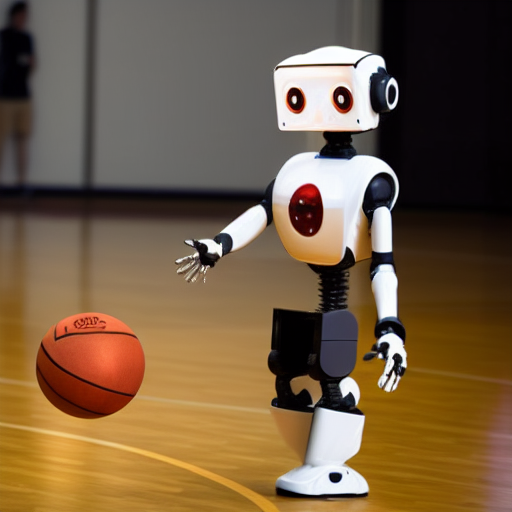

In [ ]:
device = 'cpu'

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
  device = 'cuda'
elif torch.backends.mps.is_available() and ALLOW_MPS:
  device = 'mps'

print(f"Using device: {device}")

tokenizer = CLIPTokenizer(vocab_file = vocab_file_path, merges_file = merges_file_path)
model_file = os.path.join(current_directory, 'parameters_essential_tokenizer_stable_diffusion/v1-5-pruned-emaonly.ckpt')
models = preload_models_from_standard_weights(model_file, device)


## Text to image
prompt = "A robot playing with a basketball."
# , highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution.
uncond_prompt = ""
do_cfg = True
cfg_scale = 8

## Image to image
input_image = None
image_path = "/content/drive/MyDrive/Stable_Diffusion/__keqing_and_keqing_genshin_impact_drawn_by_yabacha__f5dd65673bd3dabb2dffac4679965e0f.jpg"
# input_image = Image.open(image_path)
strength = 0.9

sampler = 'ddpm'
num_inference_steps = 50
seeds = 42

output_image = generate(
    prompt = prompt,
    uncond_prompt = uncond_prompt,
    strength = strength,
    do_cfg = do_cfg,
    cfg_scale = cfg_scale,
    sampler_name = sampler,
    n_inference_steps = num_inference_steps,
    seed = seeds,
    input_image = input_image,
    models=models,
    tokenizer=tokenizer,
    device=device,
    idle_device='cpu'
)

Image.fromarray(output_image)